# <center>Milestone 2</center> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import re
import matplotlib.cm as cm
from dateutil.relativedelta import relativedelta


# Keyword Search

import spacy
from collections import Counter
import nltk
from nltk import punkt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


# Additional functions

from helpers import*

## 1. Data Loading and Preprocessing

### 1.1) Data loading

> We begin by loading the CMU Movies Summary Corpus datasets, acquired from http://www.cs.cmu.edu/~ark/personas/, along with additional datasets required to complement our collection, obtained from https://query.wikidata.org and https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset.

In [4]:
# Paths

DATA_PATH = "data/"


# Specific paths for CMU Movies Summary Corpus datasets

MOVIES_FOLDER = DATA_PATH + "MovieSummaries/"
MOVIES_DATASET = MOVIES_FOLDER + "movie.metadata.tsv"
CHARACTERS_DATASET = MOVIES_FOLDER + "character.metadata.tsv"
CHARACTERS_NAMES_DATASET = MOVIES_FOLDER + "name.clusters.txt"
CHARACTERS_TYPES_DATASET = MOVIES_FOLDER + "tvtropes.clusters.txt"
PLOTS_DATASET = MOVIES_FOLDER + "plot_summaries.txt"


# Specific paths for additional datasets to complement the CMU Movies Summary Corpus datasets


ADDITIONAL_FOLDER = DATA_PATH + "AdditionalDatasets/"
ETHNICITIES_DATASET = ADDITIONAL_FOLDER + "ethnicities.wikidata.csv"
IMDB_DATASET = ADDITIONAL_FOLDER + "imdb_movies.csv"

In [6]:
# Loading of the CMU Movies Summary Corpus datasets

movies = pd.read_csv(MOVIES_DATASET, sep = '\t', names = ['id_wiki', 'id_freebase', 'name', 'date', 'box_office', 'runtime', 'lang', 'country', 'genre'])
characters = pd.read_csv(CHARACTERS_DATASET, sep = '\t', names = ['id_wiki_movie', 'id_freebase_movie', 'movie_release_date', 'character_name', 'actor_birth_date', 'actor_gender', 'actor_height', 'actor_ethnicity_freebase_id', 'actor_name', 'actor_age_movie_release', 'character_actor_freebase_map_id', 'character_id_freebase','actor_id_freebase'])
characters_names = pd.read_csv(CHARACTERS_NAMES_DATASET, sep = '\t', names = ['character_name', 'character_actor_freebase_map_id'])
characters_types = pd.read_csv(CHARACTERS_TYPES_DATASET, sep = '\t', names = ['character_type', 'character_actor_freebase_map_id'])
plot_summaries = pd.read_csv(PLOTS_DATASET, sep = '\t', names = ['id_wiki_movie', 'summary'])

>As we need plot summaries for our strategy to analyze the movies we decided to immediately merge the plot summaries to the movie dataset. 
>
>As we are doing an inner merge we immediately get rid of any movies that might not have any subplots as well.

In [7]:
movies_df = movies.copy() 
movie_plots = plot_summaries.copy()

# Merging movie and plot_summaries datasets

movies_and_plots = pd.merge(movies_df, movie_plots, how = 'inner', left_on = 'id_wiki', right_on = 'id_wiki_movie').copy()


print(movie_plots.shape)
print(movies_df.shape)
print(movies_and_plots.shape)

(42303, 2)
(81741, 9)
(42204, 11)


> We have chosen to enrich our datasets by incorporating ethnicities' Freebase IDs (obtained from https://query.wikidata.org) to facilitate the study of ethnicity representation in cinema.

In [8]:
# Load ethnicities metadata (ethnicities corresponding to freebase IDs obtained from wikidata) 

ethnicities_original = pd.read_csv(ETHNICITIES_DATASET, names=['wikidata_url', 'actor_ethnicity', 'actor_ethnicity_freebase_id'])


# Drop the wikidata_url as this will not be needed

ethnicities = ethnicities_original.copy().drop('wikidata_url', axis = 1)


# Merging of the ethnicities dataset into the characters dataset

characters_ethnicities = characters.merge(ethnicities, how = 'left', on = ['actor_ethnicity_freebase_id']).copy()

### 1.2) Initial data preprocessing

> In order to explore the dataset, some of the data in the movies dataset has to be preprocessed, because it is not in a format we can use. This is the case for the movie release date, the movie genre, the country of production and the movie languages.
>
>We convert the movie release date to datetime format (we decided to only keep the years for our analysis)
>
>In order to make data handling easier we convert the dictionaries to a list, keeping only the names(not the id) for the columns genre, country and language. 

In [9]:
# THIS CELL SHOULD BE RUN ONLY ONCE

movies_and_plots['date'] = pd.to_datetime(movies_and_plots['date'], errors = 'coerce', format = 'mixed').dt.year

movies_and_plots['genre'] = movies_and_plots['genre'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_and_plots['country'] = movies_and_plots['country'].copy().apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_and_plots['lang'] = movies_and_plots['lang'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')

## 2. General statistics about the movie dataset

> The aim of this first section is to explore the size of the movie dataset and get a sense of its scope.

### 2.1) Exploring the total number of movies in the dataset**

In [10]:
print("The total number of movies is :", movies_and_plots.shape[0])

The total number of movies is : 42204


### 2.2) Exploring the number of years covered by the dataset and the number of movies produced per year

In [11]:
print("Movie release years range: ", movies_and_plots['date'].min(), "-", movies_and_plots['date'].max())

Movie release years range:  1893.0 - 2014.0


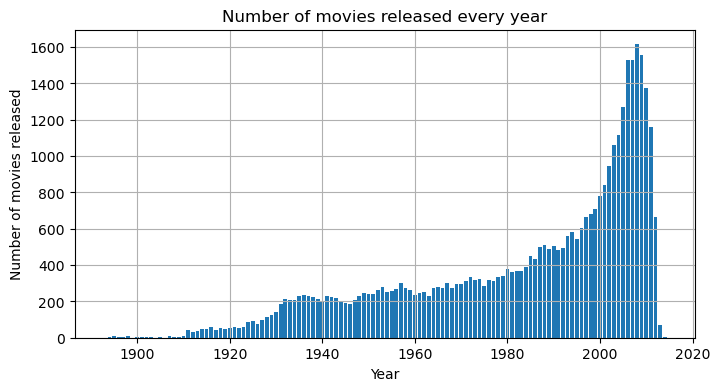

In [12]:
# Calculate the number of movies per year

movies_per_year = movies_and_plots['date'].value_counts()


# Plot the number of movies per year

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year.index, movies_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year')
plt.grid(True)
plt.show()

> nice evolution==> society had evolved however a dig into nans values are stille required to fully analyse this evolution

### 2.3) Exploring the number of NANs in the movies dataset

In [13]:
# Printing NAN values' counts and percentages in the movies' dataset for further analysis

movies_nan_analysis_df = movies_and_plots.copy()
print("MOVIES' DATASET: \n")
compute_nan_count_and_percentage(movies_nan_analysis_df)

MOVIES' DATASET: 

id_wiki: 0 NaN values, which represents 0.00 % of the column. 

id_freebase: 0 NaN values, which represents 0.00 % of the column. 

name: 0 NaN values, which represents 0.00 % of the column. 

date: 2619 NaN values, which represents 6.21 % of the column. 

box_office: 34617 NaN values, which represents 82.02 % of the column. 

runtime: 6624 NaN values, which represents 15.70 % of the column. 

lang: 0 NaN values, which represents 0.00 % of the column. 

country: 0 NaN values, which represents 0.00 % of the column. 

genre: 0 NaN values, which represents 0.00 % of the column. 

id_wiki_movie: 0 NaN values, which represents 0.00 % of the column. 

summary: 0 NaN values, which represents 0.00 % of the column. 



> While the majority of our columns have a low count of NaN values, the 'box_office' column stands out, with almost 83% of its entries being NaN. Since we consider 'box_office' to be a significant indicator of how a movie is received by society—a focal point of our study—we have decided to augment the existing dataset with an additional one, aiming to fill in the majority of the missing values.

### 2.4) Enrichment of the Dataset's Box Office

>To address the high NaN rate in the 'box_office' column, we merge the current dataset with an additional one, obtained at https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset. 

In [21]:
imdb_df = pd.read_csv(IMDB_DATASET, dtype={'column_name': str}, low_memory=False)

print(imdb_df.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [22]:
# This dataset only contains imdb_ids, while the current dataset we are working with doesn't have them

id_translations = translations_imbd_to_freebase()  # Create a DataFrame with 2 columns: one for imdb_ids, the other for corresponding freebase_ids

revenue_df_with_freebase_ids = pd.merge(imdb_df, id_translations, on = 'imdb_id', how = 'left') 

revenue_freebase = revenue_df_with_freebase_ids[['id_freebase', 'revenue']].copy() # Selectionning only the columns of interest

In [23]:
# Create a mapping dictionary from 'id_freebase' to 'revenue'
revenue_mapping = revenue_freebase.set_index('id_freebase')['revenue'].to_dict()

# Fill NaN values in 'box_office' with corresponding values from 'revenue'
movies_box_office_filled = movies_and_plots.copy()
movies_box_office_filled['box_office'] = movies_box_office_filled['box_office'].combine_first(movies_box_office_filled['id_freebase'].map(revenue_mapping))

In [27]:
nan_count_before = movies_and_plots['box_office'].isnull().sum()
print(f'Before filling with the column "revenue": Nans {nan_count_before}')

nan_count_after = movies_box_office_filled['box_office'].isnull().sum()
print(f'After filling with the column "revenue": Nans {nan_count_after}')
print(f"The new NaN percentage is {nan_count_after / movies_box_office_filled.shape[0] * 100:.1f}%")

Before filling with the column "revenue": Nans 34617
After filling with the column "revenue": Nans 21006
The new NaN percentage is 49.8%


> We were able to add about 13,000 new 'box_office' values. Despite still having 50% NaN values, this marks a significant increase compared to the initial 83%.

### 2.5) Look at countries and defining world regions

>We may want to define different regions of the world, grouping different countries together. We could define the following regions: 
>- Europe 
>- USA + Canada + Australia
>- Middle East
>- Asia
>- Africa
>- South & Central America
>
>--> Check how many movies are contained for each subdivision over time? Do we have enough movies for each division at each timepoint to be able to draw relevant conclusions?
(Here we don't only check if our partitioning is adequate but also the general timespan we can perform our analysis on: WWI may be too early)

In [32]:
# Obtain a list of countries contained in the dataset

only_countries = movies_box_office_filled['country'].copy()
only_countries = only_countries.to_list()


# Removing all Nan's and making a onedimensional list of all countries contained in the dataset

only_countries = [x for x in only_countries if x != "NaN"]
only_countries = [item for sublist in only_countries for item in sublist]


# Creating a list with all unique countries contained in the dataset

only_countries_unique = get_unique_countries(only_countries)


print(only_countries_unique)

['United States of America', 'United Kingdom', 'Germany', 'South Africa', 'Turkey', 'German Democratic Republic', 'India', 'Australia', 'New Zealand', 'Netherlands', 'Mexico', 'Canada', 'Brazil', 'Poland', 'Spain', 'Argentina', 'Japan', 'South Korea', 'Hungary', 'Pakistan', 'France', 'Yugoslavia', 'Kenya', 'England', 'Finland', 'Ireland', 'Philippines', 'West Germany', 'Hong Kong', 'China', 'Denmark', 'Soviet Union', 'Italy', 'Romania', 'Egypt', 'Czechoslovakia', 'Czech Republic', 'Israel', 'Austria', 'Indonesia', 'Belgium', 'Russia', 'Portugal', 'Lebanon', 'Iran', 'Greece', 'Uzbekistan', 'Nazi Germany', 'Norway', 'Weimar Republic', 'Morocco', 'Switzerland', 'Puerto Rico', 'Luxembourg', 'Cambodia', 'Sweden', 'Thailand', 'Taiwan', 'Chile', 'Scotland', 'Venezuela', 'Vietnam', 'Sri Lanka', 'Senegal', 'Colombia', 'Malaysia', 'Mali', 'Serbia', 'Slovakia', 'Bulgaria', 'Ukraine', 'Singapore', 'Tunisia', 'Croatia', 'Malta', 'Uruguay', 'Bosnia and Herzegovina', 'Korea', 'Monaco', 'Republic of M

In [33]:
# Create the corresponding regions for later analysis containing all countries from the dataset

europe_countries =  ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime']
middle_east_countries = ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan']
asia_countries = ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma']
africa_countries = ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau']
south_central_america_countries =  ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba']
north_america_countries = ['United States of America', 'Canada']
australia_countries = ['Australia', 'New Zealand']
outlier_countries = [ 'German Language', 'Malayalam Language'] 


# Check that all countries in the dataset are contained in a certain region

all_countries = europe_countries + middle_east_countries + asia_countries + africa_countries + south_central_america_countries + north_america_countries + australia_countries + outlier_countries
print('Number of countries in the newly defined world regions:',len(only_countries_unique))
print('Number of countries in the dataset:', len(all_countries))

Number of countries in the newly defined world regions: 147
Number of countries in the dataset: 147


>**Important Observations:**
>- A movie can be produced by multiple countries at the same time
>- In the entries of some countries, there are typos or different syntax which is why these countries are not considered identical. To avoid any effects this can have, all manners of which the country was written was included in the grouping. Examples of this are:
    - “Ukrainian SSR” vs “Ukranian SSR”
    - “Socialist Federal Republic of Yugoslavia” vs “Yugoslavia” vs “Federal Republic of Yugoslavia”
    - “Palestinian territories” vs “Palestinian Territories”
>- There are a few entries which do not correspond to countries. These were grouped into the list "outlier_countries" and will not be used for country analysis, as we cannot be completely sure what countries produced them. Examples of this are:
    - “German Language”
    - “Malayalam Language”

#### 2.5.1) Make the defined world regions more accessible by adding a new column 'world_region' to the movie dataframe

In [37]:
regions = {'europe_countries': europe_countries, 'middle_east_countries': middle_east_countries, 'asia_countries': asia_countries, 
           'africa_countries': africa_countries, 'south_central_america_countries': south_central_america_countries, 'north_america_countries': north_america_countries, 'australia_countries': australia_countries, 'outlier_countries': outlier_countries}


# Create a new column 'world_region' in the DataFrame

movies_with_regions = movies_box_office_filled.copy()
movies_with_regions['world_region'] = movies_with_regions['country'].apply(find_region, regions = regions)
movies_with_regions.sample()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,summary,world_region
42064,3751460,/m/09z1yz,Super Xuxa,1988.0,NaN,82.0,NaN,[Brazil],"[Family Film, Fantasy, Comedy]",3751460,"Meneghel plays a singer/TV star, who starts a ...",south_central_america_countries


### 2.6) Exploring the different movie genres and defining genre categories
>Since in some cases there are multiple genres for one movie, the value in the genre column is a list. In order to be able to analyze the genres separately (and not as a part of a list of genres for one given movie), we concatenated all these lists to make a big list containing all the instances of all genres.
Then we converted the list back to a pandas series, in order to directly obtain the number of movies for each genre (using value_counts()).

In [42]:
# Explode the 'genre' column to create individual rows for each genre

movies_dataframe_genre = movies_with_regions.explode('genre').copy()

# Check how many unique genre we have

unique_genres = movies_dataframe_genre['genre'].unique()
print(unique_genres.shape)
# print(unique_genres)

(364,)


> In order to better grasp and visualize more easily the genre column we decided to make genre categories.

In [40]:
# Defining overcategories of genres

action = ['Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Film noir', 'Neo-noir', 'Ninja movie', 'Superhero', 'Superhero movie', 'Samurai cinema','Apocalyptic and post-apocalyptic fiction', 'Doomsday film', 'Movies About Gladiators', 'Spy']
adult = ['Adult', 'Erotic Drama', 'Erotic thriller', 'Erotica', 'Gay pornography', 'Hardcore pornography', 'Homoeroticism', 'Pinku eiga', 'Pornographic movie', 'Pornography', 'Softcore Porn'] 
adventure = ['Action/Adventure', 'Adventure', 'Adventure Comedy', ' Costume Adventure', 'Family-Oriented Adventure', 'Fantasy Adventure', 'Sci-Fi Adventure', 'Wuxia']
animation = ['Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Clay animation', 'Computer Animation', 'Silhouette animation', 'Stop motion']
comedy = ['Action Comedy', 'Adventure Comedy', 'Black comedy', 'Comdedy', 'Comedy', 'Comedy Thriller', 'Comedy Western', 'Comedy film', 'Comedy horror', 'Comedy of Errors', 'Comedy of manners', 'Comedy-drama', 'Crime Comedy', 'Domestic Comedy', 'Ealing Comedies', 'Fantasy Comedy', 'Gross out', 'Gross-out film', 'Heavenly Comedy', 'Horror Comedy', 'Humour', 'Media Satire', 'Musical comedy', 'Parody', 'Political satire', 'Romantic comedy', 'Satire', 'Screwball comedy', 'Sex comedy', 'Slapstick', 'Stand-up comedy', 'Tragicomedy', 'Workplace Comedy']
crime = ['Biker Film', 'Buddy cop', 'Crime', 'Crime Comedy', 'Crime Drama', 'Crime Fiction', 'Crime Thriller', 'Detective', 'Detective fiction', 'Gangster Film', 'Giallo','Heist', 'Juvenile Delinquency Film', 'Law & Crime', 'Master Criminal Films', 'Mystery', 'Outlaw', 'Outlaw biker film', 'Prison', 'Prison escape', 'Prison film', 'Statutory rape', 'Whodunit']
documentary = ['Archives and records', 'Biographical film', 'Biography', 'Biopic [feature]','Culture & Society', 'Essay Film', 'Docudrama', 'Documentary', 'Education', 'Mondo film', 'Educational', 'Environmental Science', 'Film & Television History', 'Finance & Investing', 'Health & Fitness', 'Historical Documentaries', 'Journalism', 'Language & Literature', 'Libraries and librarians', 'Linguistics', 'Media Studies', 'Mockumentary','Natural disaster', 'Nature', 'News', 'Political Documetary', 'Rockumentary', 'Travel', 'World History']
drama = ['Addiction Drama', 'Cavalry Film', 'Childhood Drama', 'Comedy-drama', 'Costume drama', 'Crime Drama', 'Docudrama', 'Drama', 'Erotic Drama', 'Family Drama', 'Fantasy Drama', 'Historical drama', 'Illnesses & Disabilities', 'Inspirational Drama', 'Legal drama', 'Marriage Drama', 'Melodrama', 'Medical fiction', 'Musical Drama', 'Political drama', 'Romantic drama', 'Tragedy']
family_and_children = ['Animals', 'Buddy Picture', 'Buddy film', 'Camp', "Children's", "Children's Entertainment", "Children's/Family", 'Christmas movie', 'Coming of age', 'Coming-of-age film','Dance', 'Family & Personal Relationships', 'Family film', 'Holiday Film', 'Interpersonal Relationships', 'Jukebox musical', 'Jungle Film', 'Backstage musical', 'Musical', 'Roadshow theatrical release', 'School story']
fantasy = ["Children's Fantasy", 'Creature Film', 'Fairy tale', 'Fantasy', 'Fantasy Adventure', 'Fantasy Comedy', 'Fantasy Drama', 'Heaven-Can-Wait Fantasies', 'Mythological Fantasy', 'Monster', 'Monster movie', 'Revisionist Fairy Tale', 'Romantic fantasy', 'Supernatural', 'Sword and sorcery', 'Sword and sorcery films', 'Vampire movies', 'Werewolf fiction', 'Zombie Film']
history = ['Archaeology', 'Archives and records', 'Avant-garde', 'British Empire Film', 'Cold War', 'Film & Television History', 'Gulf War', 'Hagiography', 'Historical drama', 'Historical Epic', 'Historical fiction', 'History', 'Movies About Gladiators', 'Period piece', 'Plague', 'Samurai cinema', 'Sword and Sandal', 'The Netherlands in World War II', 'World History']
horror = ['Comedy horror', 'Costume Horror', 'Demonic child', 'Gothic film', 'Haunted House Film', 'Horror', 'Horror Comedy', 'Natural horror films', 'Period Horror', 'Psycho-biddy', 'Psychological horror', 'Road-Horror', 'Sci-Fi Horror', 'Slasher', 'Splatter film', 'Supernatural', 'Zombie Film', 'Z movie']
oldies = ['Black-and-white', 'Goat gland', 'Silent film', 'Pre-Code']
romance = ['Chick flick','Romance Film', 'Romantic comedy', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
science_fiction = ['Alien Film', 'Alien invasion','Computers', 'Dystopia', 'Future noir', 'Inventions & Innovations', 'Sci Fi Pictures original films', 'Sci-Fi Adventure', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Science Fiction', 'Science fiction Western', 'Tokusatsu', 'Space opera', 'Space western', 'Time travel']
thriller = ['Action Thrillers', 'Chase Movie', 'Comedy Thriller', 'Crime Thriller', 'Political thriller', 'Psychological thriller', 'Romantic thriller', 'Sci-Fi Thriller', 'Thriller']
war = ['Anti-war', 'Anti-war film', 'Cold War', 'Combat Films', 'Gulf War', 'Nuclear warfare', 'Private military company', 'The Netherlands in World War II', 'War effort', 'War film']
western = ['Acid western', 'B-Western', 'Comedy Western', 'Epic Western', 'Hybrid Western', 'Indian Western', 'Revisionist Western', 'Science fiction Western', 'Singing cowboy', 'Space western', 'Spaghetti Western', 'Western']
lgbtq_and_gender = ['Feminist Film', 'Gay',  ' Gay Interest', 'Gay Themed', 'Gay pornography', 'Gender Issues', 'Homoeroticism', 'LGBT', 'New Queer Cinema', 'Women in prison films']

number_genres_considered = action + adult + adventure + animation + comedy + crime + documentary + drama + family_and_children + fantasy + history + horror + oldies + romance + science_fiction + thriller + war + western + lgbtq_and_gender
print('The ratio of genres considered', len(number_genres_considered), '/', unique_genres.shape[0])


# Check how many movies are covered by these genres are:

represented_movies = movies_dataframe_genre[movies_dataframe_genre['genre'].apply(lambda x: any(item in x for item in number_genres_considered))]
represented_movies_unique = represented_movies['name'].unique()
print('Movies considered:', len(represented_movies_unique), 'out of', movies_df.shape[0])

The ratio of genres considered 292 / 364
Movies considered: 38351 out of 81741


>We can see that the ratio of genres considered is 292/364. There are some genres in the dataset that do not make sense in keeping, such as 'Short Films' or 'Bollywood', which in themselves are not really a genre but a different kind of movie categorization. It does not make sense to keep them for the analysis. Due to this however, there are quite a lot of movies that are not covered by the considered genres (38'351 out of the 42'204 movies). We tried to put as many genres into the list as possible by staying as objective as possible. The genre 'Heist' for example could be a comedy as well as a drama, however, this depends on the movie so we added this genre to neither and added it to crime instead. There are also genres that include two of our chosen over genres such as for example 'Adventure Comedy'. In these cases we added it to both over genres. For further analysis to see how the genres are represented over the years we can add our newly created genres to the movies dataframe in order to visually represent how the distribution of the genres changes over the years. The not considered movies will have a nan value in this new column.

#### 2.6.1) Make the defined genre categories more accessible by adding a new column 'new_genre' to the movie dataframe

In [45]:
genres_considered = {'action': action, 'adult': adult, 'adventure': adventure, 'animation': animation, 'comedy': comedy, 'crime': crime, 'documentary': documentary, 'drama': drama, 'family_and_children': family_and_children, 'fantasy': fantasy, 'history': history, 'horror': horror, 'oldies': oldies, 'romance': romance, 'science_fiction': science_fiction, 'thriller': thriller, 'war': war, 'western': western, 'lgbtq_and_gender': lgbtq_and_gender}


# Add a new column to the main dataframe to store the names of the genres and make them easily accessible

movies_with_genre = movies_with_regions.copy()
movies_with_genre['new_genre'] = None


# Iterate over genres_considered and update the 'new_genre' column

for name, genre_list in genres_considered.items():
    mask = movies_with_genre['genre'].apply(lambda x: any(item in x for item in genre_list))
    movies_with_genre.loc[mask, 'new_genre'] = movies_with_genre.loc[mask, 'new_genre'].apply(lambda x: [] if x is None else x)  # Initialize with an empty list if None
    movies_with_genre.loc[mask, 'new_genre'] = movies_with_genre.loc[mask, 'new_genre'].apply(lambda x: x + [name] if isinstance(x, list) else [name])
    
movies_with_genre.sample()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,summary,world_region,new_genre
32480,880056,/m/03l6q0,Scary Movie 3,2003.0,220673217.0,84.0,[English Language],"[United States of America, Canada]","[Parody, Horror, Absurdism, Gross-out film, Ho...",880056,The film opens with Katie and Becca meeting ...,north_america_countries,"[comedy, horror]"


### 2.7) Exploring the number of different languages of the movies in the dataset

> Since there might in some cases be multiple languages for one movie, we proceded similarly to 2.4) and 2.5) by first making a list containing all instances of all languages. As we only wanted to find the total number of different languages and not the number of movies for a specific language, we then converted the list to a set.

In [46]:
# Making one big list with all instances of all languages

languages_list = []
for lang in movies_with_genre['lang'] : languages_list += lang


# Number of different languages (tranforming the list into a set)

tot_languages = len(set(languages_list))

print('The total number of languages represented in the dataset is :', tot_languages)

The total number of languages represented in the dataset is : 208


### 2.8) Checking the Outliers in the movie dataset

#### 2.8.1) Outlier Characteristics of Movie Box Office Revenue

In [47]:
# Testing for outliers contained in the "box_office" column

outliers_box_office = [box for box in movies_with_genre['box_office'] if type(box) != float]
outliers_box_office_unique = list(set(outliers_box_office))
print(outliers_box_office_unique)


# Testing for box office revenues that are out of range (<0)

impossible_box_office = [box for box in movies_with_genre['box_office'] if (box < 0)]
print(impossible_box_office)

[]
[]


>Important observations of the column 'box_office':
>- Contains NaN's (NaN's are recognized as floats here, are present)
>- Apart from Nan's there are no non-float values
>- Column does not contain impossible (<0) box office revenues

>As we saw we have 90 % NaN values in the box office column. As long as we do not add a dataset to enrich this data it does not make sense to use it in our analysis.

#### 2.8.2) Outlier Characteristics of Movie Countries
> We already analyzed the countries and assigned them to their own regions. There were two notable outliers that were assigned to the 'outlier_countries': 'German Language' and 'Malayalam Language' as these are not countries we did not assign them to a world region but kept them in this seperate category.

#### 2.8.3) Outlier Characteristics of Movie Genres
> As we already analyzed the movie genres in 2.5 we already considered and looked at the outliers contained in this column.

#### 2.8.4) Outlier Characteristics of Movie Languages

In [48]:
# Testing for outliers contained in the "lang" column

languages_list_unique = list(set(languages_list))
print(languages_list_unique[:20])

['Tulu Language', 'Tamil Language', 'Assamese Language', 'Portuguese Language', 'Cree language', 'Vietnamese Language', 'France', 'Serbo-Croatian', 'Flemish language', 'Taiwanese', 'Galician Language', 'Rajasthani language', 'Tibetan languages', 'French Language', 'Nepali Language', 'Gaelic', 'Fulfulde, Adamawa Language', 'Armenian Language', 'American English', 'Bosnian language']


>Important observations of the column 'lang':
>- Some entries are not languages in the traditional sense but rather countries such as 'France', 'Hungary' and 'Japan'
>- Important to notice is that some languages may be the same but described differently for different movies (e.g. 'german' vs 'deutsch')
>- Some languages when described in their own language use a different alphabet, e.g. '𐐖𐐲𐑉𐑋𐑌𐐲'
>- When a film is a silent film this is marked by the entry 'silent film'
>- Contains invalid values such as 'a' (this is because here we have not dropped the NAN's and 'n' and 'a' are recognized as individual languages).

## 3. Associating movies to historical events and movements using dictionnaries
> The focus of our project is to study how societal events are reflected in movies. Initially, we attempted to categorize them based on their genres. However, leading our study solely according to the genres to which the movies belong seems quite challenging, as genres may not accurately reflect historical events. 
>
> As a result, we have decided to adopt another approach by mapping movies to the historical events they are linked to through a keyword search in their plot summaries. To achieve this, we created event-related dictionaries using specialized lexicons. We then engineered metrics to determine whether a movie represents a specific event or not.

### 3.1) Creation of Dictionnaries

> We decided to focus our study on several different events that dominated the past century: WW1, WW2, new technologies emergence, the Cold War, LGBTQ emancipation etc... The dictionaries are defined below and were inspired by content found on the internet (https://www.oed.com/discover/word-lists).

In [53]:
# World War 1 dictionary

ww1_dict = ['world war i', 'world war 1', 'ww1', 'wwi', '1914', '1916', '1917', '1918', 'the great war', 'verdun', 'somme', 'mustard gas', 'no man\'s land', 'armistice', 'trenches', 'trench', 'treaty of versailles', 'colonial troops', 'franz ferdinand', 'wilson', 'lusitania', 'central powers', 'league of nations', '1915', 'spanish flu', 'spanish influenza', 'first world war']


# World War 2 dictionary 

ww2_dict = ['world war ii', 'world war 2', 'ww2', 'wwii', '1939', '1940', '1941', '1942', '1943', '1944', '1945', 'axis powers', 'allied powers', 'hitler', 'churchill', 'roosevelt', 'stalin', 'holocaust', 'pearl harbor', 'hiroshima', 'nagasaki', 'nazis', 'nazi', 'concentration camps', 'fascism', 'fascist', 'dunkirk', 'atomic bomb', 'nuclear', 'united nations', 'enigma code', 'd-day', 'reich', 'resistance', 'marshall plan', 'gestapo', 'deportation', 'auschwitz', 'swastika', 'ss', 'blitzkrieg', 'stalingrad', 'internment camps', 'manhattan project', 'nuremberg trials', 'luftwaffe', 'the big three']


# Space Exploration dictionary 

space_dict = ['moon landing', '1969', 'apollo 11', 'apollo', 'space race', 'neil armstrong', 'buzz aldrin', 'michael collins', 'lunar module', 'command module', 'lunar surface', 'moon mission', 'lunar landing', 'astronauts', 'astronaut', 'flag planting', 'apollo program', 'spaceflight', 'saturn 5', 'saturn v', 'laika', 'moonwalk', 'moon rover', 'spacecraft', 'nasa', 'solar system', 'mars', 'satellite', 'satellites', 'international space station', 'iss', 'yuri gagarin', 'gagarin', 'sputnik', 'mercury program', 'vostok program', 'luna program', 'space shuttle program', 'mir space station']


# Cold War dictionary

cold_war_dict = ['nuclear arms race', 'iron curtain', 'berlin airlift', 'proxy wars', 'proxy war', 'proxy states',  'cuban missile', 'cuban revolution', 'berlin wall', 'mccarthyism', 'mutual assured destruction', 'warsaw pact', 'north atlantic treaty organization', 'sputnik', 'perestroika', 'glasnost', 'helsinki accords', 'truman doctrine', 'huac', 'house un-american activities committee', 'korean war', 'vietnam war', 'gorbachev', 'khrushchev', 'kennedy', 'stalin', 'nixon', 'truman', 'johnson', 'saigon', 'agent blue', 'agent orange', 'paris peace accords', 'napalm', 'mutually assured destruction', 'mutually-assured destruction', 'mi5', 'soviet union', 'ussr', 'mutual defense assistante act', 'nuclear deterrence', 'olympic boycott', 'olympic boycotts', 'ostpolitik', 'brandt', 'reagan', 'red scare', 'russification', 'south-east asia treaty organisation', 'seato', 'sovietisation', 'stasi', 'tet', 'checkpoint charlie', 'cold war', 'east germany', 'west germany', 'iron curtain', 'gdr', 'frg', 'ddr', 'brd', 'reunification', 'space race', 'apollo program', 'apollo 11','atomic testing', 'arms race']


# Vietnam War dictionary

vietnam_war_dict = ['vietnam war', 'ho chi minh', 'viet cong', 'viet', 'viets', 'agent orange', 'napalm', 'tet offensive', 'my lai massacre', 'hanoi', 'saigon', 'tonkin', 'paris peace accords', 'rolling thunder', 'agent blue', '1954', '1974', 'nixon', 'johnson', 'vietnamese']


# Women Emancipation dictionary 

women_emancipation_dict = ['feminism', 'suffrage', 'equal rights', 'gender equality', "women's liberation", 'female empowerment', 'female emancipation', 'gender roles', "women's rights", 'glass ceiling', 'patriarchy', 'sexism', 'feminist', 'abortion', 'women in the workplace', 'equal pay', 'maternity leave', 'body positivity', 'sexual harassment', 'sexist', 'gender wage gap', 'gender discrimination', 'domestic violence', "women's march", 'gender stereotypes', 'gender bias', 'empowering', "women's health", 'contraceptive pill', 'birth-control', 'gender inequality', 'contraception', 'wage gap', 'gender pay gap', 'seneca falls', 'suffragist', 'suffragists', 'feminists', 'reproductive rights', 'international women’s day', 'roe v. wade', 'birth control', 'gender gap', "women’s abilities", 'female engineer', 'female mathematician', 'first woman', 'first female', 'gender inequality', 'macho', 'veil']


# Black History dictionary

black_history_dict = ['black history', 'slavery', 'abolition', 'emancipation proclamation', 'underground railroad', 'jim crow laws', 'segregation', 'montgomery bus boycott', 'martin luther king jr.', 'rosa parks', 'malcolm x', 'black panthers', 'frederick douglass', 'harriet tubman', 'sojourner truth', 'booker t. washington', 'w.e.b. du bois', 'civil rights act', 'voting rights act', 'black power', 'african american culture', 'harlem renaissance', 'great migration', 'tuskegee airmen', 'buffalo soldiers', 'negro league baseball', 'black lives matter', 'kwanzaa', 'haitian revolution', 'madam cj walker', 'tuskegee experiment', 'zora neale hurston', 'shirley chisholm', 'octavius catto', 'black wall street', 'black liberation', 'slave rebellion', 'freedom riders', 'hip-hop', 'african diaspora', 'american civil war', 'kkk', 'ku klux klan', 'racism', 'racist', 'discrimination', 'segregate', 'segregated', 'colored facilities', 'first black', 'first african american', 'civil rights movement', 'martin luther king', 'juneteenth', 'slave', 'slaves', 'racists', 'apartheid', 'nelson mandela', 'mlk', 'black harlem', 'harlem renaissance', 'new negro movement']


# Digitalisation dictionary

digitalisation_dict = ['internet', 'drones', 'computer', 'mobile phone', 'web', 'robots', 'artificial intelligence', 'social media', 'hackers', 'laptop', 'screen', 'facebook', 'software', 'instagram', 'twitter', 'smartphone', 'jet', 'computers', 'mobile phones', 'darkweb', 'google', 'microsoft', 'hacking', 'cybersecurity', 'cyber-attack', 'cyber attack', 'cybercrime', 'hacker', 'drone']


# Sexuality dictionary

sexuality_dict = ['sexuality', 'gender expression', 'bdsm', 'safe sex', 'sexual health', 'sex education', 'reproductive rights', 'sex-worker', 'sexual empowerment', 'stripper', 'strip-club', 'strip club', 'sexual stigma', 'kink', 'fetish', 'polyamory', 'polygamy', 'monogamy', 'sexuality exploration', 'sexuality education', 'sexual liberation', 'pleasure activism', 'prostitute', 'sadism', 'condom', 'contraception', 'orgasm', 'masturbation', 'masturbating', 'jerking off', 'get laid', 'pornography', 'porno', 'porn', 'pornstar', 'anal', 'sextoy', 'dildo', 'libido', 'vulva', 'vagina', 'penis']


# STDs dictionary

STDs_dict = ['aids', 'hiv', 'human immunodeficiency virus', 'acquired immunodeficiency syndrome', 'antiretroviral therapy', 'hiv transmission', 'hiv testing', 'aids symptoms', 'hiv prevention', 'aids awareness', 'world aids day', 'aids activism', 'freddie mercury', 'hiv-positive', 'hiv-negative', 'sexually transmissible disease', 'std', 'syphilis', 'chlamydia', 'herpes', 'sexual health', 'gonorrhea', 'papillomavirus', 'cervical cancer', 'pelvic inflammatory disease', 'mycoplasma genitalium', 'uti', 'trichomoniasis', 'infertility', 'stds']


# Opioid crisis dictionary

opioid_crisis_dict = ['drug', 'opioid crisis', 'opioids', 'opioid', 'prescription painkillers', 'heroin', 'fentanyl', 'overdose', 'naloxone', 'substance abuse', 'pain management', 'methadone', 'morphine', 'buprenorphine', 'narcotic analgesics', 'overdosed', 'morphium', 'pain reliever', 'pain relievers', 'pain killer', 'pain killers', 'pain relief', 'syringe', 'syringes']


# Mental Health dictionary

mental_health_dict = ['psychoses', 'psychose', 'psychosis', 'schizophrene', 'schizophrenia', 'schizophrenic', 'psychiatrist', 'psychiatrists', 'psychiatric hospital', 'ptsd', 'post traumatic stress disorder', 'anxiety', 'shell shock', 'anti-depressants', 'depression', 'depressed', 'antidepressant', 'anti-depressant', 'antidepressants', 'bipolar disorder', 'bipolar', 'mental disorder', 'eating disorder', 'eating disorders', 'mental health', 'anorexia', 'burnout', 'burn-out', 'self harm', 'selfharm', 'self-harm', 'obsessive disorder', 'compulsive disorder', 'ocd', 'panic attack']


# Atomic Bomb dictionary

atomic_bomb_dict = ['manhattan project', 'oppenheimer', 'hiroshima', 'nagasaki', 'enola gay', 'trinity test', 'nuclear explosion', 'atomic testing', 'radiation effects', 'arms race', 'atomic bombings', 'fat man', 'nuclear chain reaction', 'nuclear', 'atomic']


# Genetic Engineering dictionary

genetic_engineering_dict = ['genetic', 'gene', 'genes', 'dna', 'genome', 'biotechnology', 'cloning', 'clone', 'clones', 'crispr-cas9', 'crispr', 'genetically modified', 'gmo', 'mutation', 'designer babies', 'gene therapy', 'stem cells', 'in vitro fertilization', 'ivf', 'in vitro', 'epigenetics', 'regenerative medicine', 'biohacking', 'in vivo']


# LGBTQIA+ dictionary

lgbtq_dict = ['gay', 'lesbian', 'lgbt pride', 'bisexual', 'drag queen', 'transexual', 'marriage equality', 'homosexual', 'coming out', 'homosexual rights', 'aids stigma', 'non binary', 'queer', 'freddie mercury', 'lgbtq+', 'two-spirit', 'transphobia', 'gender identity', 'lgbtqia+', 'transgender', 'gender fluid', 'asexual', 'pansexual', 'same-sex marriage', 'transsexual', 'non-binary', 'bisexuality', 'homosexuality', 'transsexuality', 'homophobia', 'homophobic', 'gender dysphoria', 'stonewall', 'lgbt', 'lgbtq', 'sexual orientation', 'drag show', 'drag performance', 'sex change', 'gender affirming surgery']


# Terrorism dictionary

terrorism_dict = ['terrorism', 'terrorist', 'terrorist attack', 'suicide bombing', 'suicide bomb', 'suicide bomber', '9-11', 'twin towers', 'hostage crisis', 'jihad', 'al-qaeda', 'bin laden', 'boeing 767', 'pentagon', 'flight 11', 'flight 175', 'flight 77', 'flight 93', 'hijacking', 'hijackers', 'hijacker', 'hijacked', 'isis', 'islamic state', 'explosive belt', 'counterterrorism', 'counter-terrorism', 'terrorists', 'nine eleven', 'september 11', 'homeland security', 'world trade center', 'north tower', 'south tower']

In [54]:
# List of events/movements and list of associated dictionaries

events = ['WW1', 'WW2', 'Space', 'Cold War', 'Vietnam war', 'Women emancipation', 'Black History', 'Digitalisation', 'Sexuality', 'STDs', 'Opioid Crisis', 'Mental Health', 'Atomic Bomb', 'Genetic Engineering', 'LGBTQ', 'Terrorism' ]
dictionaries = [ww1_dict, ww2_dict, space_dict, cold_war_dict, vietnam_war_dict, women_emancipation_dict, black_history_dict, digitalisation_dict, sexuality_dict, STDs_dict, opioid_crisis_dict, mental_health_dict, atomic_bomb_dict, genetic_engineering_dict, lgbtq_dict, terrorism_dict]
new_dictionaries = []


# Change the layout of the dictionaries to prepare for word search (replace `', '` with ` | `)

for el in dictionaries:
    new_dictionaries.append('|'.join(el))


# Create a DataFrame for 'events' dictionaries

dictionaries_df = pd.DataFrame(list(zip(events, new_dictionaries)), columns=['events', 'dictionaries'])
dictionaries_df = dictionaries_df.set_index('events')

### 3.2) Categorizing Movies Through Keyword Search in Plot Summaries
> Our approach involves setting a threshold for each dictionary, indicating the minimum number of matching words required to classify a movie as belonging to an event.
>
>We decide to initialize it at 1 for all dictionaries, and we might adjust the thresholds later.
>

In [57]:
# Set word search threshhold to 1 (means that 1 dictionary-specific word in the plot summary is enough to match to the corresponding event) 

dictionaries_df['threshold'] = 1

In [58]:
# The next cell takes a little bit of time to run

movies_events = movies_with_genre.copy()
movies_events = add_event_columns(movies_events, dictionaries_df)

print(movies_events.columns)


In [61]:
# Checking how many movies were associated to an event

movies_events_df = movies_events[movies_events[events].any(axis=1)].copy()
movies_events_df = create_events_belongs_to_column(movies_events_df, events).copy()

print(movies_events_df.shape)
movies_events_df.sample()

(35670, 30)


,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,id_wiki_movie,...,Digitalisation,Sexuality,STDs,Opioid Crisis,Mental Health,Atomic Bomb,Genetic Engineering,LGBTQ,Terrorism,events_belongs_to
11141,9833036,/m/02ptg57,Rekava,1956.0,NaN,89.0,[Sinhala Language],[Sri Lanka],[Drama],9833036,...,False,False,False,False,False,False,False,False,False,[WW2]


>More than 10,000 movies out of 40,000 were selected to represent one or more historical events.

In [73]:
movies_per_event = {}

# Iterate through each event
for event in events:
    movies_per_event[event] = movies_events_df[movies_events_df['events_belongs_to'].apply(lambda x: event in x)]

    # Print the number of movies per event
    print(f'{event}:', movies_per_event[event].shape[0])

WW1: 1895
WW2: 32667
Space: 11041
Cold War: 2393
Vietnam war: 1260
Women emancipation: 990
Black History: 1107
Digitalisation: 4111
Sexuality: 2547
STDs: 8350
Opioid Crisis: 2689
Mental Health: 1679
Atomic Bomb: 638
Genetic Engineering: 5386
LGBTQ: 1444
Terrorism: 1260


### 3.3) Checking the Quality of our dictionaries

#### 3.3.1) Correlation Matrix

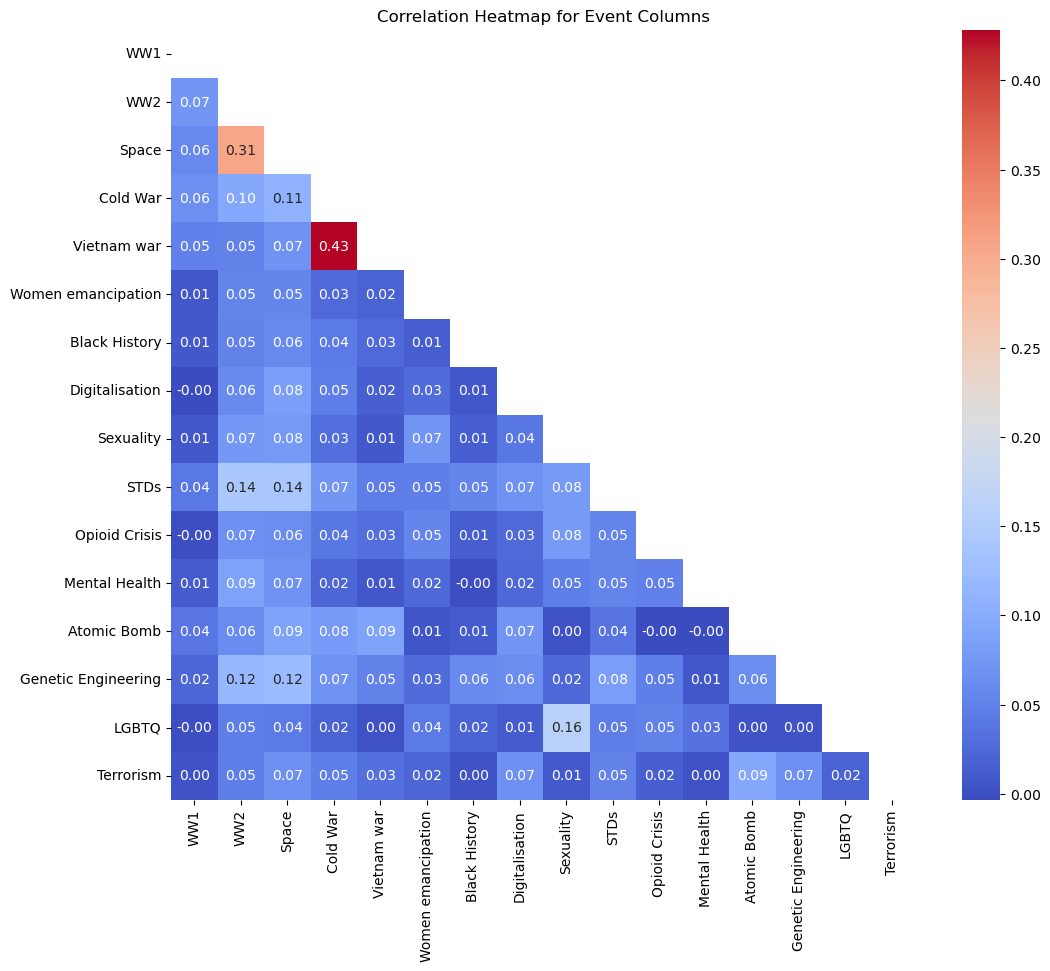

In [71]:
df = movies_events.copy()
df[events] = df[events].astype(int)  # Converting booleans into integers

correlation_matrix = df[events].corr() # Create a correlation matrix

mask = np.triu(np.ones_like(correlation_matrix, dtype = bool)) # Create a mask for the upper triangle

# Set up the matplotlib figure

plt.figure(figsize = (12, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", mask = mask)
plt.title("Correlation Heatmap for Event Columns")
plt.show()

3.3.1) now with counts

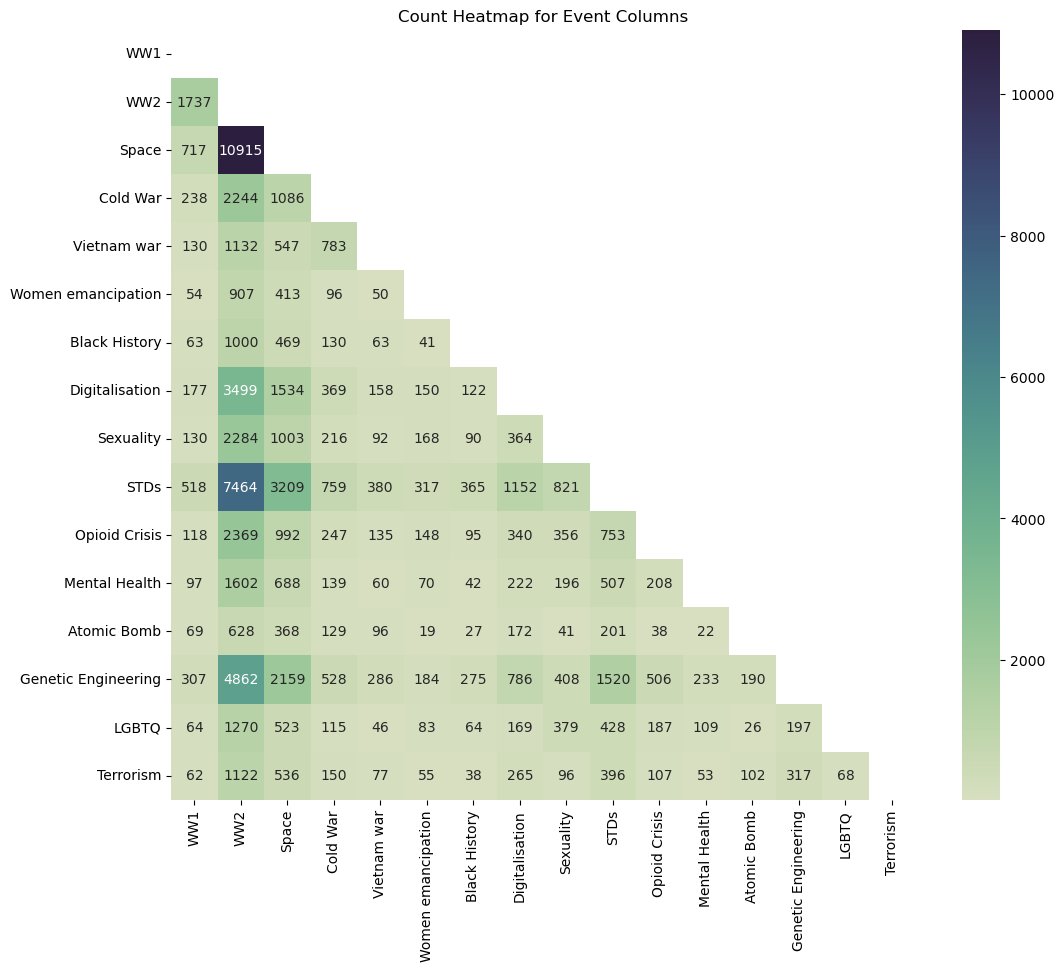

In [72]:
count_matrix = df[events].T.dot(df[events]) # Create a DataFrame with counts of occurrences

mask = np.triu(np.ones_like(count_matrix, dtype=bool)) # Create a mask for the upper triangle

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a custom color map
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(count_matrix, annot=True, cmap=cmap, fmt="d", mask=mask)

plt.title("Count Heatmap for Event Columns")
plt.show()

>Comment: We have decided to only represent half of the matrix, as this will minimize computation time. The second half of the heatmap would not give us any new information.

>COMMENTS ON THE MATRIX ITSELF??

#### 3.3.2) Checking Accuracy of our Dictionaries

##### 3.3.2.1) False Negatives

>In order to test the accuracy of our dictonary-based classification, we created a 'testing set' of movies for which we already know to which event/movement they belong. We then used our dictionaries to match each movie to a certain event or movement. By comparing the dictionnary-mapped events and the given event, we were able to assess the accuracy of our dictionnaries. We used the percentage of correctly matched movies as an indicator for accuracy.

In [23]:
# Creating the test sets : dataframes of movies with known associated event or movement

# Test subset for WW1

ww1_test_set = pd.DataFrame({
    'id_wiki': [354122, 4592959, 1198629, 6361585, 5403512, 5501736, 7133888, 73368, 62097, 23255],
    'id_freebase': ['/m/01znj1', '/m/0cbl95', '/m/04gm93', '/m/0g2h97', '/m/0dk937', '/m/0dpq1q', '/m/0h5ys_', '/m/0jq1x', '/m/0gsx1', '/m/05sjq'],
    'name': ['Gallipoli', 'All Quiet on the Western Front', 'Aces High', 'The Red Baron', 'Flyboys', 'Darling Lili', 'The Lost Patrol', 'The Big Parade', 'Grand Illusion', 'Paths of Glory'],
    'date': ['1981', '1930-04-21', '1976', '2008-03-31', '2006-09-22', '1970-06-24', '1934-02-16', '1925', '1937', '1957']
})
ww1_test_set['true_event'] = 'WW1' 


# Test subset for WW2

ww2_test_set = pd.DataFrame({
    'id_wiki': [57585, 4492505, 8994, 182164, 633052, 14725310, 28269, 65834, 42159, 42856],
    'id_freebase': ['/m/0ft18', '/m/0c5d5j', '/m/02h22', '/m/018wsw', '/m/02yvct', '/m/0gy0l_', '/m/07024', '/m/0hfzr', '/m/0bl5c', '/m/0bs4r'],
    'name': ['Casablanca', 'Come and See', 'Das Boot', 'Grave of the Fireflies', 'Inglourious Basterds', 'Letters from Iwo Jima', 'Saving Private Ryan', "Schindler's List", 'The Best Years of Our Lives', 'The Bridge on the River Kwai'],
    'date': ['1942-11-26', '1985', '1981-09-17', '1988-04-16', '2009-05-20', '2006-12-09', '1998-07-24', '1993-11-30', '1946', '1957-10-02']
})
ww2_test_set['true_event'] = 'WW2' 


# Test subset for Space Exploration

space_exploration_test_set = pd.DataFrame({
    'id_wiki': [142417, 6446053, 113442, 1110047, 13887546, 11378430, 879000, 4338909, 3146408, 103325],
    'id_freebase': ['/m/011yd2', '/m/025twgf', '/m/0sxgv', '/m/046vs6', '/m/03cm7j_', '/m/02r9hx1', '/m/03l3hv', '/m/0bxy6l', '/m/08vf0c', '/m/0q23s'],
    'name': ['Apollo 13', 'Dr. No', 'The Right Stuff', 'October Sky', 'From the Earth to the Moon', 'The Mouse on the Moon', 'Destination Moon', 'Countdown', 'G.O.R.A.', 'Royal Space Force: The Wings of Honneamise'],
    'date': ['1995-06-22', '1962-10-05', '1983-10-21', '1999-02-19', '1958', '1963', '1950-06-27', '1968', '2004-11-12', '1987-03-14']
})
space_exploration_test_set['true_event'] = 'Space' 


# Test subset for Cold War

cold_war_test_set = pd.DataFrame({
    'id_wiki': [464883, 1129041, 37241569, 566713, 113442, 34130, 5454803, 2663129, 58147, 8695],
    'id_freebase': ['/m/02crgz', '/m/048scx', '/m/0n53wvj', '/m/02qrv7', '/m/0sxgv', '/m/08720', '/m/0dmn0x', '/m/07w8fz', '/m/0fy66', '/m/02dwj'],
    'name': ['Miracle', 'Thirteen Days', 'Cold War', 'The Living Daylights', 'The Right Stuff', 'WarGames', 'The Lives of Others', 'Good Night, and Good Luck.', 'The Manchurian Candidate', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb'],
    'date': ['2004-02-06', '2000-12-16', '2012-11-08', '1987', '1983-10-21', '1983-06-03', '2006-03-15', '2005-09-01', '1962-10-24', '1964-01-29']
})
cold_war_test_set['true_event'] = 'Cold War' 


# Test subset for Vietnam War

vietnam_war_test_set = pd.DataFrame({
    'id_wiki': [18951054, 11701, 1011468, 3859075, 168593, 2478590, 675947, 103011, 1546168, 113460],
    'id_freebase': ['/m/0jzw', '/m/0333t', '/m/03z106', '/m/0b3nrz', '/m/016kxf', '/m/07gv6d', '/m/0320br', '/m/0p_qr', '/m/0599rp', '/m/0sxmx'],
    'name': ['Apocalypse Now', 'Full Metal Jacket', 'We Were Soldiers', 'Rescue Dawn', 'Good Morning, Vietnam', 'Tigerland', 'Hamburger Hill', 'Coming Home', 'Heaven & Earth', 'Platoon'],
    'date': ['1979-05-10', '1987-06-17', '2002-02-25', '2006-09-09', '1987-12-23', '2000-10-06', '1987-08-28', '1978-02-15', '1993-12-13', '1986-12-19']
})
vietnam_war_test_set['true_event'] = 'Vietnam war' 


# Test subset for Women Emancipation

women_emancipation_test_set = pd.DataFrame({
    'id_wiki': [1164646, 390693, 25594421, 2148370, 74018, 5527808, 11347793, 176762, 444267, 249876],
    'id_freebase': ['/m/04cq1k', '/m/022npf', '/m/09rvcvl', '/m/06qbrw', '/m/0jsxn', '/m/0dq_ss', '/m/02r8hh_', '/m/017zss', '/m/0296vv', '/m/01l2b3'],
    'name': ['Iron Jawed Angels', 'Born in Flames', 'Made in Dagenham', 'North Country', 'His Girl Friday', 'The Joy Luck Club', 'Persepolis', 'Whale Rider', 'Legally Blonde', 'Bend It Like Beckham'],
    'date': ['2004-01-16', '1983', '2010-09-11', '2005-10-21', '1940-01-11', '1993-09-08', '2007-06-27', '2002-09-09', '2001-06-26', '2002-04-11']
})
women_emancipation_test_set['true_event'] = 'Women emancipation' 


# Test subset for Black History

black_history_test_set = pd.DataFrame({
    'id_wiki': [300972, 73428, 29454281, 225487, 2084045, 155997, 1073955, 19032190, 73428, 397574],
    'id_freebase': ['/m/01rwyq', '/m/0jqkh', '/m/0ds3t5x', '/m/01gvwd', '/m/06l2pj', '/m/014gcy', '/m/043ncp', '/m/09rsjpv', '/m/0jqkh', '/m/023gxx'],
    'name': ['Malcolm X', 'Do the Right Thing', 'The Help', 'Claudine', 'Crooklyn', 'Boyz N the Hood', 'Soul Food', 'Red Tails', 'Do the Right Thing', 'Remember the Titans'],
    'date': ['1992-11-18', '1989-05', '2011-08-10', '1974', '1994-05-13', '1991-07-02', '1997-09-26', '2012-01-20', '1989-05', '2000-09-23']
})
black_history_test_set['true_event'] = 'Black History' 


# Test subset for Digitalisation

digitalization_test_set = pd.DataFrame({
    'id_wiki': [23941708, 30007, 34344124, 3746, 672934, 142224, 4273140, 1368785, 306195, 49696],
    'id_freebase': ['/m/08ct6', '/m/07cz2', '/m/07gp9', '/m/017n9', '/m/031qr5', '/m/011xg5', '/m/0bth54', '/m/04x7w0', '/m/01sk1v', '/m/0d6b7'],
    'name': ['2001: A Space Odyssey', 'The Matrix', 'Terminator 2: Judgment Day', 'Blade Runner', 'The Lawnmower Man', 'A.I. Artificial Intelligence', 'Avatar', 'Freejack', 'The Net', 'Metropolis'],
    'date': ['1968-04-06', '1999-03-31', '1991-07-01', '1982-06-25', '1992-03-06', '2001-06-26', '2009-12-10', '1992-01-17', '1995-07-28', '1927-01-10']
})
digitalization_test_set['true_event'] = 'Digitalisation' 


# Test subset for Sexuality

sexuality_test_set = pd.DataFrame({
    'id_wiki': [4838538, 44122, 1988806, 226842, 615121, 2141418, 2457326, 1897341, 28075240, 195388],
    'id_freebase': ['/m/0cqbfc', '/m/0c0zq', '/m/06c753', '/m/01h1zp', '/m/02wtp6', '/m/06ptw1', '/m/07fg13', '/m/064lsn', '/m/0cmc26r', '/m/01brqv'],
    'name': ['Summer with Monika', 'American Beauty', 'Lolita', 'Ken Park', 'The Dreamers', 'Mysterious Skin', 'Palindromes', 'The Pianist', 'A Dangerous Method', 'Y tu mamá también'],
    'date': ['1953', '1999-09-08', '1997-09-27', '2002-08-31', '2003-09-01', '2004-09-03', '2005-01-21', '2002-05-24', '2011-09-02', '2001-06-08']
})
sexuality_test_set['true_event'] = 'Sexuality' 


# Test subset for STDs

stds_test_set = pd.DataFrame({
    'id_wiki': [615418, 6256985, 28194808, 2046284, 11517671, 23266463, 468353, 543162, 13699003, 1367539],
    'id_freebase': ['/m/02ww1t', '/m/0fz68f', '/m/0cnx21r', '/m/06hbq5', '/m/02rgktd', '/m/065_f26', '/m/02d49z', '/m/02nczh', '/m/03cffvv', '/m/04x4rr'],
    'name': ['Kids', 'Teenage Caveman', 'Black Venus', "She's Too Young", 'Damaged Lives', 'Girl, Positive', 'Thirteen', "Boys Don't Cry", 'And the Band Played On', 'Longtime Companion'],
    'date': ['1995-05', '2002', '2010-09', '2004-02-16', '1933', '2007-06-25', '2003-01-17', '1999-09-02', '1993-09-11', '1989-10']
})
stds_test_set['true_event'] = 'STDs' 


# Test subset for Opioid Crisis

opioid_crisis_test_set = pd.DataFrame({
    'id_wiki': [37599, 23830211, 3182907, 105434, 5842075, 1611072, 2470904, 1380618, 2244939, 6179073],
    'id_freebase': ['/m/09cr8', '/m/07k2mq', '/m/08xnxg', '/m/0qf2t', '/m/0f8j13', '/m/05gjj1', '/m/07gb81', '/m/04y2j6', '/m/06yv1n', '/m/0fvcx9'],
    'name': ['Traffic', 'Requiem for a Dream', 'The Basketball Diaries', 'Trainspotting', 'Fear and Loathing in Las Vegas', 'A Scanner Darkly', '28 Days', 'Permanent Midnight', 'Clean and Sober', 'Less Than Zero'],
    'date': ['2001-01-05', '2000-10-27', '1995-04-21', '1996-02-23', '1998-05-15', '2006-07-07', '2000-02-08', '1998-09-16', '1988', '1987-11-06']
})
opioid_crisis_test_set['true_event'] = 'Opioid Crisis' 


# Test subset for Mental Health

mental_health_test_set = pd.DataFrame({
    'id_wiki': [54160, 33502433, 3383952, 7047921, 3569822, 106335, 26971354, 12685170, 9114950, 24480838],
    'id_freebase': ['/m/0f4vx', '/m/0h95927', '/m/098s2w', '/m/0h1x5f', '/m/09m6kg', '/m/0qm98', '/m/0fpkhkz', '/m/02x0fs9', '/m/027y5ys', '/m/09k56b7'],
    'name': ['Leaving Las Vegas', 'The Silver Linings Playbook', 'Girl, Interrupted', 'Little Miss Sunshine', 'A Beautiful Mind', 'Ordinary People', 'Melancholia', 'Lars and the Real Girl', 'Fight Club - Members Only', 'Black Swan'],
    'date': ['1995-09-15', '2012-11-21', '1999-12-08', '2006-01-20', '2001-12-13', '1980-09-19', '2011-05-18', '2007-09-10', '2006-02-17', '2010-09-01']
})
mental_health_test_set['true_event'] = 'Mental Health' 


# Test subset for Atomic Bomb

atomic_bomb_test_set = pd.DataFrame({
    'id_wiki': [8695, 123464, 993867, 936429, 242542, 37068, 8863891, 31607, 18735140, 31629],
    'id_freebase': ['/m/02dwj', '/m/0x2j1', '/m/03xj57', '/m/03rk23', '/m/01k5_t', '/m/097r7', '/m/027mh15', '/m/07s5y', '/m/04gppzp', '/m/07sc1'],
    'name': ['Dr. Strangelove, or: How I Learned to Stop Worrying and Love the Bomb', 'Fail-Safe', "By Dawn's Early Light", 'Miracle Mile', 'Testament', 'The War Game', 'When the Wind Blows', 'The Day After', 'Barefoot Gen', 'Threads'],
    'date': ['1964-01-29', '1964-10-07', '1990-05-19', '1988-09-11', '1932', '1965', '1986-10', '1983-11-20', '1983', '1984']
})
atomic_bomb_test_set['true_event'] = 'Atomic Bomb' 


# Test subset for Genetic Engineering

genetic_engineering_test_set = pd.DataFrame({
    'id_wiki': [30340901, 146947, 42886, 3746, 27098, 31893898, 50957, 14899108, 456601, 1168522],
    'id_freebase': ['/m/0gwm_wy', '/m/012s1d', '/m/0bscw', '/m/017n9', '/m/06r2_', '/m/0gvrtf4', '/m/0dfw0', '/m/02qr2tx', '/m/02bqxb', '/m/04d0ng'],
    'name': ['Elysium', 'Spider-Man', 'Gattaca', 'Blade Runner', 'Star Trek II: The Wrath of Khan', 'The Deep Blue Sea', 'Star Wars Episode II: Attack of the Clones', 'Splice', 'The Fly', 'Mimic'],
    'date': ['2013-03-01', '2002-05-03', '1997-09-07', '1982-06-25', '1982-06-04', '2011-09-11', '2002-05-16', '2009-10-06', '1986-08-15', '1997-08-22']
})
genetic_engineering_test_set['true_event'] = 'Genetic Engineering' 


# Test subset for LGBTQIA+

lgbtq_test_set = pd.DataFrame({
    'id_wiki': [3146002, 1367539, 61664, 1856185, 24207129, 15782460, 4752795, 33025020, 455013, 468293],
    'id_freebase': ['/m/08vd2q', '/m/04x4rr', '/m/0gpx6', '/m/061dj0', '/m/07l50_1', '/m/03ntf1h', '/m/0clh4y', '/m/0fpmrmq', '/m/02bk82', '/m/02d41336193'],
    'name': ['Sunday Bloody Sunday', 'Longtime Companion', 'All About My Mother', 'Jeffrey', 'A Single Man', 'Hedwig and the Angry Inch', 'Before Night Falls', 'Pariah', 'The Boys in the Band', 'Philadelphia'],
    'date': ['1971', '1989-10', '1999-04-08', '1995', '2009-09-11', '2001-01-19', '2001-01-26', '2011-01-20', '1970-03-17', '1993']
})
lgbtq_test_set['true_event'] = 'LGBTQ' 


# Test subset for Terrorism

terrorism_test_set = pd.DataFrame({
    'id_wiki': [1891886, 34953010, 15497901, 185058, 2311219, 16733548, 33028800, 3634311, 106328, 2174599],
    'id_freebase': ['/m/0645k5', '/m/0j43swk', '/m/03mc6yp', '/m/0198lt', '/m/072x7s', '/m/0404j37', '/m/0h03fhx', '/m/09r94m', '/m/0qm8b', '/m/06sfk6'],
    'name': ['V for Vendetta', 'Zero Dark Thirty', 'The Baader Meinhof Complex', '9/11', 'Munich', 'The Hurt Locker', 'Argo', 'United 93', 'Black Hawk Down', 'The Siege'],
    'date': ['2006-02-13', '2012-12-19', '2008-09-25', '2002-03-10', '2005-12-23', '2008-09-04', '2012-08-31', '2006-04-28', '2001-12-18', '1998-11-06']
})
terrorism_test_set['true_event'] = 'Terrorism'

In [25]:
# Joining all these test sets into one big dataframe

movies_test_set = pd.concat([ww1_test_set, ww2_test_set, space_exploration_test_set, cold_war_test_set, vietnam_war_test_set, women_emancipation_test_set, black_history_test_set, digitalization_test_set, sexuality_test_set, stds_test_set, opioid_crisis_test_set, mental_health_test_set, atomic_bomb_test_set, genetic_engineering_test_set, lgbtq_test_set, terrorism_test_set], ignore_index=True)

movie_plots = plot_summaries.copy()


# Merge movies_test_set and plot_summaries datasets

merged_test_set_plots = pd.merge(movies_test_set, movie_plots, how = 'left', left_on = 'id_wiki', right_on = 'id_wiki_movie')


# Match each movie to an event using our dictionaries

movies_test_set_events = add_event_columns(merged_test_set_plots, dictionaries_df).copy()
movies_test_set_events = create_events_belongs_to_column(movies_test_set_events, events).copy()

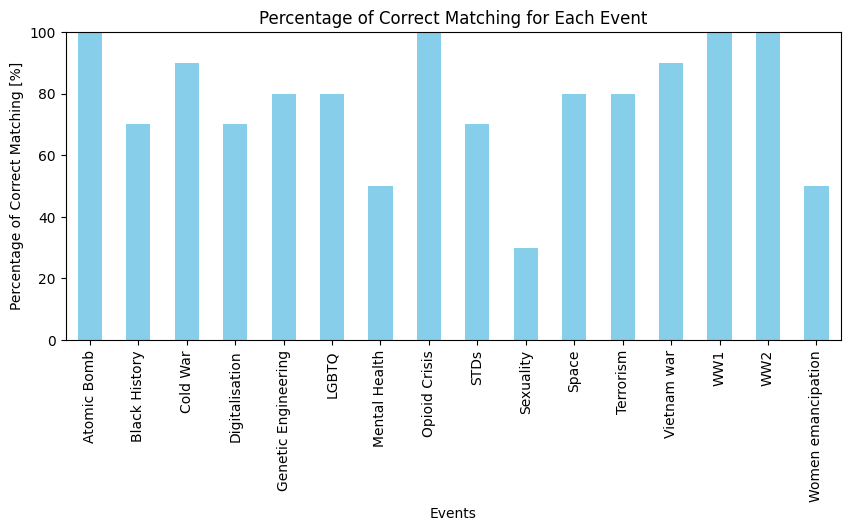

In [26]:
# Check matching and create a new column 'correct_matching'

movies_test_set_events['correct_matching'] = movies_test_set_events.apply(check_matching, axis=1)


# Calculate the percentage of correct matching for each event/movement

movies_test_set_events_grouped = movies_test_set_events.groupby('true_event')['correct_matching'].mean() * 100


# Plot

plt.figure(figsize=(10, 4))
movies_test_set_events_grouped.plot(kind='bar', color='skyblue')
plt.title('Percentage of Correct Matching for Each Event')
plt.xlabel('Events')
plt.ylabel('Percentage of Correct Matching [%]')
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.show()

>The idea is to set a threshold (for example 80%) that will allow us to select only the most accurate dictionaries for the event-classification.

##### 3.3.2.2) False Positives

>In order to test the accuracy of our dictonary-based classification, we created a 'testing set' of movies for which we already know that they should not belong to any of our events. We then used our dictionaries to try to match each of these movies to a certain event or movement (which they should not be able to do). We use the percentage of incorrectly matched movies as an indicator for inaccuracy.

> The movies that we chose to test these are the following:
>'Princess Mononoke', 'The Day After Tomorrow', 'Grown Ups', 'The Notebook', 'The Incredible Hulk', 'The Lion King', 'Gladiator', 'Casino Royale', 'Star Wars Episode IV: A New Hope', 'In Time'

In [101]:
# Evaluate the false positives for each event

id_freebase_false_positive_test = ['/m/0652f', '/m/024l2y', '/m/0640m69', '/m/047tsx3', '/m/0dnkmq', '/m/0m63c', '/m/09q5w2', '/m/03r0g9', '/m/0dtfn', '/m/0dr_xmk']

ww1_false_positive = 0
ww2_false_positive = 0
cold_war_false_positive = 0
space_race_false_positive = 0
vietnam_war_false_positive = 0
women_emancipation_false_positive = 0
black_history_false_positive = 0
digitalisation_false_positive = 0
sexuality_false_positive = 0
stds_false_positive = 0
opioid_crisis_false_positive = 0
mental_health_false_positive = 0
atomic_bomb_false_positive = 0
genetic_engineering_false_positive = 0
lgbtq_false_positive = 0
terrorism_false_positive = 0


for element in id_freebase_false_positive_test:
    movie_to_test = movies_events.query('id_freebase == @element')
    if list(movie_to_test['WW1'])[0]:
        ww1_false_positive = ww1_false_positive + 1
    if list(movie_to_test['WW2'])[0]:
        ww2_false_positive = ww2_false_positive + 1
    if list(movie_to_test['Space'])[0]:
        space_race_false_positive = space_race_false_positive + 1
    if list(movie_to_test['Cold War'])[0]: 
        cold_war_false_positive = cold_war_false_positive + 1
    if list(movie_to_test['Vietnam war'])[0]:
        vietnam_war_false_positive = vietnam_war_false_positive + 1
    if list(movie_to_test['Women emancipation'])[0]:
        women_emancipation_false_positive = women_emancipation_false_positive + 1
    if list(movie_to_test['Black History'])[0]:
        black_history_false_positive = black_history_false_positive + 1
    if list(movie_to_test['Digitalisation'])[0]:
        digitalisation_false_positive = digitalisation_false_positive + 1
    if list(movie_to_test['Sexuality'])[0]: 
        sexuality_false_positive = sexuality_false_positive + 1
    if list(movie_to_test['STDs'])[0]: 
        stds_false_positive = stds_false_positive + 1
    if list(movie_to_test['Opioid Crisis'])[0]:
        opioid_crisis_false_positive = opioid_crisis_false_positive + 1
    if list(movie_to_test['Mental Health'])[0]:
        mental_health_false_positive = mental_health_false_positive + 1
    if list(movie_to_test['Atomic Bomb'])[0]:
        atomic_bomb_false_positive = atomic_bomb_false_positive + 1
    if list(movie_to_test['Genetic Engineering'])[0]:
        genetic_engineering_false_positive = genetic_engineering_false_positive + 1
    if list(movie_to_test['LGBTQ'])[0]:
        lgbtq_false_positive = lgbtq_false_positive + 1
    if list(movie_to_test['Terrorism'])[0]:
        terrorism_false_positive = terrorism_false_positive + 1

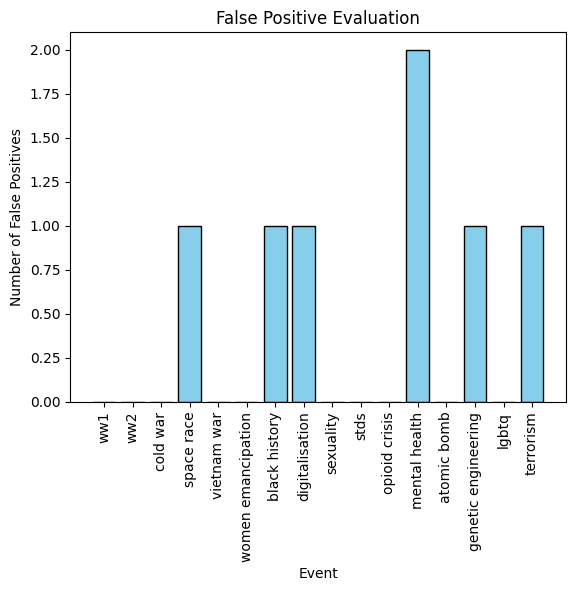

In [102]:
# Plotting the False positives for each event

false_positives = [ww1_false_positive, ww2_false_positive, cold_war_false_positive, space_race_false_positive, vietnam_war_false_positive, women_emancipation_false_positive, black_history_false_positive, digitalisation_false_positive, sexuality_false_positive, stds_false_positive, opioid_crisis_false_positive, mental_health_false_positive, atomic_bomb_false_positive, genetic_engineering_false_positive, lgbtq_false_positive, terrorism_false_positive]
x_labels = ['ww1', 'ww2', 'cold war', 'space race', 'vietnam war', 'women emancipation', 'black history', 'digitalisation', 'sexuality', 'stds', 'opioid crisis', 'mental health', 'atomic bomb', 'genetic engineering', 'lgbtq', 'terrorism']


plt.bar(x_labels, false_positives, color='skyblue', edgecolor='black')
plt.xlabel('Event')
plt.ylabel('Number of False Positives')
plt.title('False Positive Evaluation')

plt.xticks(rotation='vertical') 
plt.show()

## 4 Evaluating the impact of events on society

#### 4.1) Number of movies per event

CREATING ASSOCIATION PLOT

In [ ]:
# Creating a plot showing the number of movies for each event over the years

fig, axs = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# WW1
ww1_df['date'] = pd.to_datetime(ww1_df['date'], errors='coerce')
ww1_df['year'] = ww1_df['date'].dt.year
movies_per_year_WW1 = ww1_df.groupby('year').size().reset_index(name='YearCount')
axs[0, 0].bar(movies_per_year_WW1['year'], movies_per_year_WW1['YearCount'])
axs[0, 0].set_title('WW1')

# WW2
ww2_df['date'] = pd.to_datetime(ww2_df['date'], errors='coerce')
ww2_df['year'] = ww2_df['date'].dt.year
movies_per_year_WW2 = ww2_df.groupby('year').size().reset_index(name='YearCount')
axs[0, 1].bar(movies_per_year_WW2['year'], movies_per_year_WW2['YearCount'])
axs[0, 1].set_title('WW2')

# Space
space_df['date'] = pd.to_datetime(space_df['date'], errors='coerce')
space_df['year'] = space_df['date'].dt.year
movies_per_year_space = space_df.groupby('year').size().reset_index(name='YearCount')
axs[0, 2].bar(movies_per_year_space['year'], movies_per_year_space['YearCount'])
axs[0, 2].set_title('Space')

# Cold War
cold_war_df['date'] = pd.to_datetime(cold_war_df['date'], errors='coerce')
cold_war_df['year'] = cold_war_df['date'].dt.year
movies_per_year_cold_war = cold_war_df.groupby('year').size().reset_index(name='YearCount')
axs[0, 3].bar(movies_per_year_cold_war['year'], movies_per_year_cold_war['YearCount'])
axs[0, 3].set_title('Cold War')

# Vietnam War
vietnam_war_df['date'] = pd.to_datetime(vietnam_war_df['date'], errors='coerce')
vietnam_war_df['year'] = vietnam_war_df['date'].dt.year
movies_per_year_vietnam_war = vietnam_war_df.groupby('year').size().reset_index(name='YearCount')
axs[1, 0].bar(movies_per_year_vietnam_war['year'], movies_per_year_vietnam_war['YearCount'])
axs[1, 0].set_title('Vietnam War')

# Women emancipation
women_emancipation_df['date'] = pd.to_datetime(women_emancipation_df['date'], errors='coerce')
women_emancipation_df['year'] = women_emancipation_df['date'].dt.year
movies_per_year_women_emancipation = women_emancipation_df.groupby('year').size().reset_index(name='YearCount')
axs[1, 1].bar(movies_per_year_women_emancipation['year'], movies_per_year_women_emancipation['YearCount'])
axs[1, 1].set_title('Women Emancipation')

# Black History
black_history_df['date'] = pd.to_datetime(black_history_df['date'], errors='coerce')
black_history_df['year'] = black_history_df['date'].dt.year
movies_per_year_black_history = black_history_df.groupby('year').size().reset_index(name='YearCount')
axs[1, 2].bar(movies_per_year_black_history['year'], movies_per_year_black_history['YearCount'])
axs[1, 2].set_title('Black History')

# Digitalisation
digitalisation_df['date'] = pd.to_datetime(digitalisation_df['date'], errors='coerce')
digitalisation_df['year'] = digitalisation_df['date'].dt.year
movies_per_year_digitalisation = digitalisation_df.groupby('year').size().reset_index(name='YearCount')
axs[1, 3].bar(movies_per_year_digitalisation['year'], movies_per_year_digitalisation['YearCount'])
axs[1, 3].set_title('Digitalisation')

# Sexuality
sexuality_df['date'] = pd.to_datetime(sexuality_df['date'], errors='coerce')
sexuality_df['year'] = sexuality_df['date'].dt.year
movies_per_year_sexuality = sexuality_df.groupby('year').size().reset_index(name='YearCount')
axs[2, 0].bar(movies_per_year_sexuality['year'], movies_per_year_sexuality['YearCount'])
axs[2, 0].set_title('Sexuality')

# STDs
stds_df['date'] = pd.to_datetime(stds_df['date'], errors='coerce')
stds_df['year'] = stds_df['date'].dt.year
movies_per_year_stds = stds_df.groupby('year').size().reset_index(name='YearCount')
axs[2, 1].bar(movies_per_year_stds['year'], movies_per_year_stds['YearCount'])
axs[2, 1].set_title('STDs')

# Opioid Crisis
opioid_crisis_df['date'] = pd.to_datetime(opioid_crisis_df['date'], errors='coerce')
opioid_crisis_df['year'] = opioid_crisis_df['date'].dt.year
movies_per_year_opioid_crisis = opioid_crisis_df.groupby('year').size().reset_index(name='YearCount')
axs[2, 2].bar(movies_per_year_opioid_crisis['year'], movies_per_year_opioid_crisis['YearCount'])
axs[2, 2].set_title('Opioid Crisis')

# Mental Health
mental_health_df['date'] = pd.to_datetime(mental_health_df['date'], errors='coerce')
mental_health_df['year'] = mental_health_df['date'].dt.year
movies_per_year_mental_health = mental_health_df.groupby('year').size().reset_index(name='YearCount')
axs[2, 3].bar(movies_per_year_mental_health['year'], movies_per_year_mental_health['YearCount'])
axs[2, 3].set_title('Mental Health')

# Atomic Bomb
atomic_bomb_df['date'] = pd.to_datetime(atomic_bomb_df['date'], errors='coerce')
atomic_bomb_df['year'] = atomic_bomb_df['date'].dt.year
movies_per_year_atomic_bomb = atomic_bomb_df.groupby('year').size().reset_index(name='YearCount')
axs[3, 0].bar(movies_per_year_atomic_bomb['year'], movies_per_year_atomic_bomb['YearCount'])
axs[3, 0].set_title('Atomic Bomb')

# Genetic Engineering
genetic_engineering_df['date'] = pd.to_datetime(genetic_engineering_df['date'], errors='coerce')
genetic_engineering_df['year'] = genetic_engineering_df['date'].dt.year
movies_per_year_genetic_engineering = genetic_engineering_df.groupby('year').size().reset_index(name='YearCount')
axs[3, 1].bar(movies_per_year_genetic_engineering['year'], movies_per_year_genetic_engineering['YearCount'])
axs[3, 1].set_title('Genetic Engineering')

# LGBTQ
lgbtq_df['date'] = pd.to_datetime(lgbtq_df['date'], errors='coerce')
lgbtq_df['year'] = lgbtq_df['date'].dt.year
movies_per_year_lgbtq = lgbtq_df.groupby('year').size().reset_index(name='YearCount')
axs[3, 2].bar(movies_per_year_lgbtq['year'], movies_per_year_lgbtq['YearCount'])
axs[3, 2].set_title('LGBTQ')

# Terrorism
terrorism_df['date'] = pd.to_datetime(terrorism_df['date'], errors='coerce')
terrorism_df['year'] = terrorism_df['date'].dt.year
movies_per_year_terrorism = terrorism_df.groupby('year').size().reset_index(name='YearCount')
axs[3, 3].bar(movies_per_year_terrorism['year'], movies_per_year_terrorism['YearCount'])
axs[3, 3].set_title('Terrorism')

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Number of movies released')
    ax.grid(True)

    
# Hide x labels and tick labels for top plots and y ticks for right plots.

for ax in axs.flat:
    ax.label_outer()

plt.show()

We can observe in these graphs when certain movements started to be reflected in the movie industry. However, it is difficult to compare the different events, as later events such as digitalisation may be represented in a higher number of movies due to the general growth of the movie industry in later years. To account for this factor, we will analyze the percentage that movies of a certain event constitute of the total movies released in a year.

In [38]:
merged_movie_plots_no_nans = movies_df.dropna(subset=['date']).copy()
movies_with_summaries_per_year = merged_movie_plots_no_nans.groupby('date').size().reset_index(name = 'YearCount')
movies_with_summaries_per_year.columns = ['year', 'total count']
movies_with_summaries_per_year['year'] = movies_with_summaries_per_year['year'].astype(int)

# WW1
movies_per_year_WW1['year'] = movies_per_year_WW1['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_WW1, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_WW1['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#WW2
movies_per_year_WW2['year'] = movies_per_year_WW2['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_WW2, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_WW2['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Space
movies_per_year_space['year'] = movies_per_year_space['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_space, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_space['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Cold War
movies_per_year_cold_war['year'] = movies_per_year_cold_war['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_cold_war, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_cold_war['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Vietnam War
movies_per_year_vietnam_war['year'] = movies_per_year_vietnam_war['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_vietnam_war, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_vietnam_war['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Women emancipation
movies_per_year_women_emancipation['year'] = movies_per_year_women_emancipation['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_women_emancipation, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_women_emancipation['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Black History
movies_per_year_black_history['year'] = movies_per_year_black_history['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_black_history, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_black_history['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Digitalisation
movies_per_year_digitalisation['year'] = movies_per_year_digitalisation['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_digitalisation, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_digitalisation['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Sexuality
movies_per_year_sexuality['year'] = movies_per_year_sexuality['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_sexuality, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_sexuality['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#STDs
movies_per_year_stds['year'] = movies_per_year_stds['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_stds, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_stds['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Opioid Crisis
movies_per_year_opioid_crisis['year'] = movies_per_year_opioid_crisis['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_opioid_crisis, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_opioid_crisis['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Mental Health
movies_per_year_mental_health['year'] = movies_per_year_mental_health['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_mental_health, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_mental_health['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Atomic Bomb
movies_per_year_atomic_bomb['year'] = movies_per_year_atomic_bomb['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_atomic_bomb, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_atomic_bomb['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Genetic Engineering
movies_per_year_genetic_engineering['year'] = movies_per_year_genetic_engineering['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_genetic_engineering, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_genetic_engineering['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#LGBTQ
movies_per_year_lgbtq['year'] = movies_per_year_lgbtq['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_lgbtq, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_lgbtq['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

#Terrorism
movies_per_year_terrorism['year'] = movies_per_year_terrorism['year'].astype(int)
merged_movies_per_year_df = pd.merge(movies_per_year_terrorism, movies_with_summaries_per_year, on='year', how='left')
movies_per_year_terrorism['year percentage'] = (merged_movies_per_year_df['YearCount'] / merged_movies_per_year_df['total count']) * 100

In [ ]:
# Creating a plot showing the number of movies for each event over the years
fig, axs = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# WW1
axs[0, 0].bar(movies_per_year_WW1['year'], movies_per_year_WW1['year percentage'])
axs[0, 0].set_title('WW1')

# WW2
axs[0, 1].bar(movies_per_year_WW2['year'], movies_per_year_WW2['year percentage'])
axs[0, 1].set_title('WW2')

# Space
axs[0, 2].bar(movies_per_year_space['year'], movies_per_year_space['year percentage'])
axs[0, 2].set_title('Space')

# Cold War
axs[0, 3].bar(movies_per_year_cold_war['year'], movies_per_year_cold_war['year percentage'])
axs[0, 3].set_title('Cold War')

# Vietnam War
axs[1, 0].bar(movies_per_year_vietnam_war['year'], movies_per_year_vietnam_war['year percentage'])
axs[1, 0].set_title('Vietnam War')

# Women emancipation
axs[1, 1].bar(movies_per_year_women_emancipation['year'], movies_per_year_women_emancipation['year percentage'])
axs[1, 1].set_title('Women Emancipation')

# Black History
axs[1, 2].bar(movies_per_year_black_history['year'], movies_per_year_black_history['year percentage'])
axs[1, 2].set_title('Black History')

# Digitalisation
axs[1, 3].bar(movies_per_year_digitalisation['year'], movies_per_year_digitalisation['year percentage'])
axs[1, 3].set_title('Digitalisation')

# Sexuality
axs[2, 0].bar(movies_per_year_sexuality['year'], movies_per_year_sexuality['year percentage'])
axs[2, 0].set_title('Sexuality')

# STDs
axs[2, 1].bar(movies_per_year_stds['year'], movies_per_year_stds['year percentage'])
axs[2, 1].set_title('STDs')

# Opioid Crisis
axs[2, 2].bar(movies_per_year_opioid_crisis['year'], movies_per_year_opioid_crisis['year percentage'])
axs[2, 2].set_title('Opioid Crisis')

# Mental Health
axs[2, 3].bar(movies_per_year_mental_health['year'], movies_per_year_mental_health['year percentage'])
axs[2, 3].set_title('Mental Health')

# Atomic Bomb
axs[3, 0].bar(movies_per_year_atomic_bomb['year'], movies_per_year_atomic_bomb['year percentage'])
axs[3, 0].set_title('Atomic Bomb')

# Genetic Engineering
axs[3, 1].bar(movies_per_year_genetic_engineering['year'], movies_per_year_genetic_engineering['year percentage'])
axs[3, 1].set_title('Genetic Engineering')

# LGBTQ
axs[3, 2].bar(movies_per_year_lgbtq['year'], movies_per_year_lgbtq['year percentage'])
axs[3, 2].set_title('LGBTQ')

# Terrorism
axs[3, 3].bar(movies_per_year_terrorism['year'], movies_per_year_terrorism['year percentage'])
axs[3, 3].set_title('Terrorism')

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Percentage of total movie releases')
    ax.grid(True)
    ax.set_ylim(0, 55) # We set this to 55, since we want to be able to see the general trend. In addition, the only two percentages exceeding are outliers
    ax.label_outer()


plt.show()

Perform an ANOVA test, to compare the different events regarding the percentage of movies produced each year. With this test we want to see whether one of the events 'outperforms' the others, in other words to see whether there is a statistical difference between the events.

In [ ]:
from scipy.stats import f_oneway


sample_ww1 = movies_per_year_WW1['year percentage'].reset_index()
sample_ww2 = movies_per_year_WW2['year percentage'].reset_index()
sample_space = movies_per_year_space['year percentage'].reset_index()
sample_cold_war = movies_per_year_cold_war['year percentage'].reset_index()
sample_vietnam_war = movies_per_year_vietnam_war['year percentage'].reset_index()
sample_women_emancipation = movies_per_year_women_emancipation['year percentage'].reset_index()
sample_black_history = movies_per_year_black_history['year percentage'].reset_index()
sample_digitalisation = movies_per_year_digitalisation['year percentage'].reset_index()
sample_sexuality = movies_per_year_sexuality['year percentage'].reset_index()
sample_stds = movies_per_year_stds['year percentage'].reset_index()
sample_opioid_crisis = movies_per_year_opioid_crisis['year percentage'].reset_index()
sample_mental_health = movies_per_year_mental_health['year percentage'].reset_index()
sample_atomic_bomb = movies_per_year_atomic_bomb['year percentage'].reset_index()
sample_genetic_engineering = movies_per_year_genetic_engineering['year percentage'].reset_index()
sample_lgbtq = movies_per_year_lgbtq['year percentage'].reset_index()
sample_terrorism = movies_per_year_terrorism['year percentage'].reset_index()

In [ ]:
samples_unified = [sample_ww1, sample_ww2, sample_space,sample_cold_war, sample_vietnam_war, sample_women_emancipation, sample_black_history, sample_digitalisation, sample_sexuality, sample_stds, sample_opioid_crisis, sample_mental_health, sample_atomic_bomb, sample_genetic_engineering, sample_lgbtq, sample_terrorism]

result_ANOVA = f_oneway(*[df['year percentage'] for df in samples_unified])
print("F-statistic:", result_ANOVA.statistic)
print("P-value:", result_ANOVA.pvalue)

#### 4.2) Number of countries where a event was put into a movie

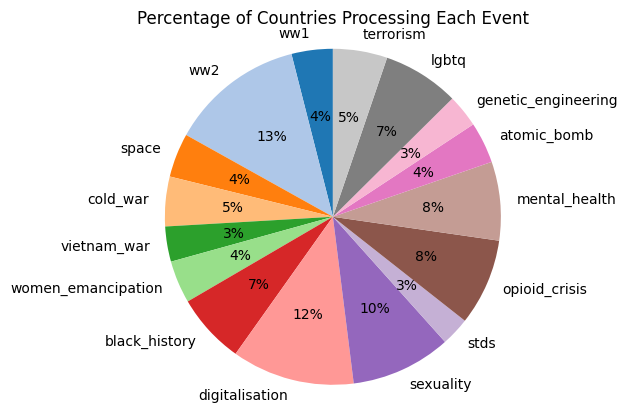

In [71]:
# Count the number of unique countries in the specified column for each DataFrame

unique_country_counts = [df['country'].apply(tuple).nunique() for df in dataframes_events]
labels_events = ['ww1', 'ww2', 'space', 'cold_war', 'vietnam_war', 'women_emancipation', 'black_history', 'digitalisation', 'sexuality', 'stds', 'opioid_crisis', 'mental_health', 'atomic_bomb', 'genetic_engineering', 'lgbtq', 'terrorism']

# Define a custom color palette
colors = plt.cm.tab20.colors[:len(labels_events)]

# Create a bar plot

plt.pie(unique_country_counts, labels=labels_events, autopct='%1.0f%%', startangle=90, colors = colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Percentage of Countries Processing Each Event')


plt.show()

In [72]:
# Calculate the coefficient of variation
cv = np.std(unique_country_counts) / np.mean(unique_lists_counts)

# Print the coefficient of variation
print(f'Coefficient of Variation: {cv}')

# You can also print other measures such as standard deviation
print(f'Standard Deviation: {np.std(unique_lists_counts)}')

Coefficient of Variation: 0.48525160754234764
Standard Deviation: 67.26800409555794


#### 4.3) Box office revenue

In [ ]:
# temporaire
revenue_df = pd.read_csv("movies_metadata.csv", dtype={'column_name': str}, low_memory=False)

In [ ]:
# To address the high NaN rate in the 'box_office' column, we merge the current dataset with an additional one, obtained at https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset. 

# Loading 
# ADDITIONAL_DATA = DATA_PATH  + "AdditionalDatasets/"
# REVENUE_DATASET = ADDITIONAL_DATA + "movies_metadata.csv"

#revenue_df = pd.read_csv(REVENUE_DATASET, dtype={'column_name': str}, low_memory=False)
#print(revenue_df.columns)

In [ ]:
# This dataset only contains imdb_ids, while the current dataset we are working with doesn't have them

id_translations = translations_imbd_to_freebase()  # Create a DataFrame with 2 columns: one for imdb_ids, the other for corresponding freebase_ids

revenue_df_with_freebase_ids = pd.merge(revenue_df, id_translations, on = 'imdb_id', how = 'left') 

revenue_freebase = revenue_df_with_freebase_ids[['id_freebase', 'revenue']].copy() # Selectionning only the columns of interest


In [ ]:
# Analysis with the movies_with_events dataset

movies_events = pd.read_csv("movies_with_events.csv") #je load ici mais faire par rapport au dataset du context de la pipeline

In [ ]:
# Create a mapping dictionary from 'id_freebase' to 'revenue'
revenue_mapping = revenue_freebase.set_index('id_freebase')['revenue'].to_dict()

# Fill NaN values in 'box_office' with corresponding values from 'revenue'
movies_events_box_office_filled = movies_events.copy()
movies_events_box_office_filled['box_office'] = movies_events['box_office'].combine_first(movies_events['id_freebase'].map(revenue_mapping))


In [ ]:
nan_count_before = movies_events['box_office'].isnull().sum()
print(f'Before filling with the column "revenue": Nans {nan_count_before}')

nan_count_after = movies_events_box_office_filled['box_office'].isnull().sum()
print(f'After filling with the column "revenue": Nans {nan_count_after}')

In [ ]:
# Sama analysis but restricting the dataset with only movies with at least one event = True

# CETTE LIGNE EST DEJA PRESENTE EN DESSOUS DES DICTIONNAIRES DES EVENTS:
events = ['WW1', 'WW2', 'Space', 'Cold War', 'Vietnam war', 'Women emancipation', 'Black History', 'Digitalisation', 'Sexuality', 'STDs', 'Opioid Crisis', 'Mental Health', 'Atomic Bomb', 'Genetic Engineering', 'LGBTQ', 'Terrorism' ]

filtered_movie_with_events = movies_events[movies_events[events].any(axis=1)].copy()
print(filtered_movie_with_events.shape)

filtered_movie_with_events_filled = movies_events_box_office_filled[movies_events_box_office_filled[events].any(axis=1)].copy()
print(filtered_movie_with_events_filled.shape)

nan_count_before = filtered_movie_with_events['box_office'].isnull().sum()
print(f'Before filling with the column "revenue": Nans {nan_count_before}')

nan_count_after = filtered_movie_with_events_filled['box_office'].isnull().sum()
print(f'After filling with the column "revenue": Nans {nan_count_after}')

#### 4.4) Rating

#### 4.5) Review - Sentiment analysis

#### 4.6) Big Actors Sandra?

## 5. Maybe helpful extra codes

In [ ]:
 ## EXTRA
## Plot the distribution of the different genres over the decades

# Extract the decade from the 'date' column
movies_dataframe = movies_df.copy()
movies_dataframe['decade'] = (movies_dataframe['date'] // 10) * 10
# Create a new DataFrame with columns for 'decade' and 'new_genre'
df_stacked = movies_dataframe[['decade', 'new_genre']].explode('new_genre')
# Count occurrences of each genre per decade
genre_counts = df_stacked.groupby(['decade', 'new_genre']).size().unstack(fill_value=0)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize = (18, 8), gridspec_kw = {'width_ratios': [2, 3]})

# Plot the stack plot
cmap = cm.get_cmap('tab20c', len(genre_counts.columns))  # Get a custom color for each genre
colors = {genre: cmap(i) for i, genre in enumerate(genre_counts.columns)}

genre_counts.plot(kind = 'bar', stacked = True, ax = axes[0], color = colors)
x_labels = ['{}s'.format(decade) for decade in genre_counts.index]
axes[0].set_xticklabels(x_labels)
axes[0].set_title('Movie Genres Over Time by Decade - Stack Plot')
axes[0].set_xlabel('Decade')
axes[0].set_ylabel('Number of Movies')
axes[0].set_xticklabels(x_labels, rotation = 30, ha = 'right')
axes[0].legend(title = 'Genre', loc = 'upper left')

# Plot the heatmap
sns.heatmap(genre_counts, cmap = "YlGnBu", annot = True, fmt = 'd', cbar_kws = {'label': 'Number of Movies'}, ax = axes[1])
axes[1].set_title('Heatmap of Movie Genres Over Time by Decade')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Decade')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = 30, ha = 'right')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

We can see that there has been a general increase in movies over the decades. This is not necessarily specific to the individual genres, however, we do see differences the increase of the number of movies. One outlier is the oldies genre which includes, silent movies, black and white movies and so on, there are less and less movies made that fall into this category. Since the dataset only goes until 2016 it makes sense that we cannot see the general increase in number of movies over the years, as we do not get the data for the full decade. So when considering decades it might make sense to only consider the data until the year 2010.

In [ ]:
##PLOT GENRES PER EVENT!
# DISCLAIMER CETTE PARTIE A ETE INSPIRÉ DE GIANNA
genres_considered = {'action': action, 'adult': adult, 'adventure': adventure, 'animation': animation, 'comedy': comedy, 'crime': crime, 'documentary': documentary, 'drama': drama, 'family_and_children': family_and_children, 'fantasy': fantasy, 'history': history, 'horror': horror, 'oldies': oldies, 'romance': romance, 'science_fiction': science_fiction, 'thriller': thriller, 'war': war, 'western': western, 'lgbtq_and_gender': lgbtq_and_gender}


# UN MERGED AVEC LA PARTIE DE GIANNA POURRAIT SUFFIR

movies_events_genres = movies_events_bis.copy()
movies_events_genres = update_new_genre_column(movies_events_bis, genres_considered)

lgbt_counts = count_genres_for_event(movies_events_genres, 'LGBTQ')
#print(lgbt_counts)

#COMPARE WITH LGBTQ_GENDER COUNT IN NEW_MODEL EXPLODED?

result = calculate_genre_proportions_by_event(movies_events_genres.copy())
result = result.dropna(axis=1, how='all')


plt.figure(figsize=(14,12))
heat_map = sns.heatmap(genre_proportions_by_event, linewidth = 1 , annot = True, cmap='Blues')
plt.title( "Genre proportion by historical event" )
plt.show()

5.2) plot movie box revenues of regions against time. How do we want to take the effect of inflation into account?

In [ ]:
## PEUTETRE ON PEUT REUTILISER CE CODE SI JAMAIS ON TROUVE UN MOYEN D'ENRICHIR LE BOXPLOT

#Using the regions from
# Check how many movies are contained for each subdivision over time, constructing subplots with individual y-axes

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)

# Check for Region Europe
boxoffice_per_year_europe = filtered_europe_movies.groupby('date')['box_office'].sum()
axs[0, 0].bar(boxoffice_per_year_europe.index, boxoffice_per_year_europe.values)
axs[0, 0].set_title('Europe')


# Check for Region Middle East
boxoffice_per_year_middle_east = filtered_middle_east_movies.groupby('date')['box_office'].sum()
axs[0, 1].bar(boxoffice_per_year_middle_east.index, boxoffice_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')

# Check for Region Asia
boxoffice_per_year_asia = filtered_asia_movies.groupby('date')['box_office'].sum()
axs[0, 2].bar(boxoffice_per_year_asia.index, boxoffice_per_year_asia.values)
axs[0, 2].set_title('Asia')

# Check for Region Africa
boxoffice_per_year_africa = filtered_africa_movies.groupby('date')['box_office'].sum()
axs[0, 3].bar(boxoffice_per_year_africa.index, boxoffice_per_year_africa.values)
axs[0, 3].set_title('Africa')

# Check for region South Central America
boxoffice_per_year_south_central_america = filtered_south_central_america_movies.groupby('date')['box_office'].sum()
axs[1, 0].bar(boxoffice_per_year_south_central_america.index, boxoffice_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')

# Check for region Other (includes USA, Australia, New Zealand, Canada)
boxoffice_per_year_other = filtered_other_movies.groupby('date')['box_office'].sum()
axs[1, 1].bar(movies_per_year_other.index, boxoffice_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')

# Check for region North America
boxoffice_per_year__north_america = filtered_north_america_movies.groupby('date')['box_office'].sum()
axs[1, 2].bar(movies_per_year_north_america.index, boxoffice_per_year__north_america.values)
axs[1, 2].set_title('North America')

#Check for region Australia
boxoffice_per_year__australia = filtered_australia_movies.groupby('date')['box_office'].sum()
axs[1, 3].bar(movies_per_year_australia.index, boxoffice_per_year__australia.values)
axs[1, 3].set_title('Australia')




for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Box office per year')
    ax.grid(True)

    
# Hide x labels and tick labels for top plots and y ticks for right plots.

for ax in axs.flat:
    ax.label_outer()

plt.show()

> We can see that the box office of the different regions vary. Europe's box office values go up with time. In the Middle East, Asia, Africa and South Central America the boxoffice values are quite low compared to the others. For the Other regions we get interesting results as there are multiple individual peaks. In order to check the result we also added individual results for North America and Australia with similar results. As we saw in 3.2 There are 73340 NAN values in the box_office column of the dataset, which corresponds to a percentage of 89.72 % of the box_office column total data.z
This is a high number in NANs showing, that these plots and the data underlying them is not very helpful with analyzing the movie dataset.

5.3) plot average number of languages spoken in movies against time for each region.

In [ ]:
#maybe add code to 3.1!!
regions = {'europe_countries': ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime'],
'middle_east_countries': ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan'],
'asia_countries': ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma'],
'africa_countries': ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau'],
'south_central_america_countries': ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba'],
'other_countries': ['United States of America', 'Canada', 'Australia', 'New Zealand'],
'outlier_countries': [ 'German Language', 'Malayalam Language'] }


# Create a new column 'world_region' in the DataFrame
movies_dataframe['world_region'] = movies_dataframe['country'].apply(find_region, regions = regions)

movies_dataframe.head()

In [ ]:
# Group by 'date' and 'region' and calculate the mean number of languages spoken in the 'lang' column for each year and region
lang_per_year_region = movies_dataframe.groupby(['date', 'world_region'])[['lang']].apply(lambda x: pd.Series({'mean': np.mean(x['lang'].apply(len)), 'variance': np.var(x['lang'].apply(len))}))

# Reset the index to make 'world_region' a regular column
lang_per_year_region = lang_per_year_region.reset_index()

# Pivot the DataFrame for plotting
lang_per_year_region_pivot = lang_per_year_region.pivot(index='date', columns='world_region', values=['mean', 'variance'])

# Remove 'outlier_countries' from the regions list
regions = [region for region in lang_per_year_region_pivot.columns.get_level_values(1).unique() if region != 'outlier_countries']

#Plot in subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axs array for easy iteration
axs_flat = axs.flatten()

# Plot mean values
for i, region in enumerate(regions):
        region_data_mean = lang_per_year_region_pivot[('mean', region)]
        region_data_variance = lang_per_year_region_pivot[('variance', region)]

        axs_flat[i].plot(region_data_mean, 'o', label=f'{region} - Mean')
        axs_flat[i].fill_between(region_data_mean.index, region_data_mean - np.sqrt(region_data_variance), region_data_mean + np.sqrt(region_data_variance), alpha=0.3)

         # Add title and legend to each subplot
        axs_flat[i].set_title(region)
            

# Adjust layout
plt.tight_layout()
plt.show()


We can see that there we do not have enough movies for each region to be able to consistently analyze the number of languages spoken in the movies made in those regions. The closer we come to today the more movies we get and therefore the more dots(means) and also more variance. It is quite interesting to see that there was a drop around 1930 in Europe and the US. We might be able to analyze this to see if we can link it to one historical event. However, we would need to do further analyses to see whether this drop was maybe linked to the number of movies and so on.

5.4) plot percentage of women in movies over time in different regions. How does this plot change when looking at percentage of female main characters?

In [ ]:
# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_gender_df = characters[['id_wiki_movie', 'actor_gender']].copy()


# Number of characters per movie

characters_per_movie = characters_gender_df.value_counts(subset = ['id_wiki_movie'])
characters_per_movie.name = 'characters_per_movie'


# Number of characters per movie for each genre

women_per_movie = characters_gender_df.value_counts(subset = ['id_wiki_movie', 'actor_gender'])


# Number of female characters per movie (set number of male characters to 0 and then sum characters from both genders)

women_per_movie = women_per_movie.to_frame().reset_index()
women_per_movie.loc[women_per_movie['actor_gender'] != 'F', 'count'] = 0
women_per_movie = women_per_movie.drop(['actor_gender'], axis = 1)
women_per_movie = women_per_movie.groupby('id_wiki_movie')['count'].sum()
women_per_movie.name = 'women_per_movie'


# Merge number of characters and number of female characters per movie into one dataframe : character_stats_per_movie

character_stats_per_movie = characters_per_movie.to_frame().merge(women_per_movie, how = 'left', on = 'id_wiki_movie')


# Calculate proportion of female characters per movie

character_stats_per_movie['proportion_women'] = character_stats_per_movie['women_per_movie']/character_stats_per_movie['characters_per_movie']
character_stats_per_movie.index.names = ['id_wiki']


# Merge proportion of female characters with movies dataframe
# Allow to have information about time and places related to proportion of female characters

character_stats_movies = character_stats_per_movie.merge(movies_df, how = 'left', on = 'id_wiki')
character_stats_movies = character_stats_movies[['proportion_women', 'date', 'country']]

In [ ]:
# Average proportion of female characters in movies per year globally

proportion_women_per_year = character_stats_movies.groupby('date')['proportion_women'].mean()


# Plotting the average proportion of female characters in movies per year

plt.figure(figsize = (8, 4))
plt.bar(proportion_women_per_year.index, proportion_women_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average proportion of female characters')
plt.title('Average proportion of female characters in movies over the years globally')
plt.grid(True)
plt.show()

In [ ]:
# Plot average proportion of female characters in movies per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average proportion of female characters in movies per year for different regions', fontsize = 20)


# Region : Europe

character_stats_movies_europe = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
proportion_women_per_year_europe = character_stats_movies_europe.groupby('date')['proportion_women'].mean()

axs[0, 0].bar(proportion_women_per_year_europe.index, proportion_women_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].grid(True)


# Region : Middle East

character_stats_movies_middle_east = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
proportion_women_per_year_middle_east = character_stats_movies_middle_east.groupby('date')['proportion_women'].mean()

axs[0, 1].bar(proportion_women_per_year_middle_east.index, proportion_women_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].grid(True)


# Region : Asia

character_stats_movies_asia = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
proportion_women_per_year_asia = character_stats_movies_asia.groupby('date')['proportion_women'].mean()

axs[0, 2].bar(proportion_women_per_year_asia.index, proportion_women_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].grid(True)


# Region : Africa

character_stats_movies_africa = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
proportion_women_per_year_africa = character_stats_movies_africa.groupby('date')['proportion_women'].mean()

axs[0, 3].bar(proportion_women_per_year_africa.index, proportion_women_per_year_africa.values)
axs[0, 3].set_title('Africa')
axs[0, 3].grid(True)


# Region : South Central America

character_stats_movies_south_central_america = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
proportion_women_per_year_south_central_america = character_stats_movies_south_central_america.groupby('date')['proportion_women'].mean()

axs[1, 0].bar(proportion_women_per_year_south_central_america.index, proportion_women_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')
axs[1, 0].grid(True)


# Region : Other

character_stats_movies_other = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
proportion_women_per_year_other = character_stats_movies_other.groupby('date')['proportion_women'].mean()

axs[1, 1].bar(proportion_women_per_year_other.index, proportion_women_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 1].grid(True)


# Region : North America

character_stats_movies_north_america = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
proportion_women_per_year_north_america = character_stats_movies_north_america.groupby('date')['proportion_women'].mean()

axs[1, 2].bar(proportion_women_per_year_north_america.index, proportion_women_per_year_north_america.values)
axs[1, 2].set_title('North America')
axs[1, 2].grid(True)


# Region : Australia

character_stats_movies_australia = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
proportion_women_per_year_australia = character_stats_movies_australia.groupby('date')['proportion_women'].mean()

axs[1, 3].bar(proportion_women_per_year_australia.index, proportion_women_per_year_australia.values)
axs[1, 3].set_title('Australia')
axs[1, 3].grid(True)


plt.tight_layout()
plt.show()

In general, we can see that the proportion of female characters is not drastically different around the world. We can also see that it is significantly lower than 50%, closer to 30%, suggesting that the gender distribution in movies is not equal. 

One region that stands out is South Central America, where the proportion of female characters is slightly higher than in other regions.

We can also note that there is much less data in the Middle East, Africa and Australia regions. This could be due to less movies being produced in these countries, or a lack of information about the gender of characters.

5.5) Plot average age actors over the years and in different regions at movie release date. How does this change if we separate age data based on gender?

In [ ]:
from dateutil.relativedelta import relativedelta


# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_actor_age_df = characters[['id_wiki_movie', 'movie_release_date', 'actor_birth_date']].copy()


# Preprocessing : convert dates to datetime format and drop NaNs

characters_actor_age_df['movie_release_date'] = pd.to_datetime(characters_actor_age_df['movie_release_date'], errors = 'coerce', utc = True, format = 'mixed')
characters_actor_age_df['actor_birth_date'] = pd.to_datetime(characters_actor_age_df['actor_birth_date'], errors = 'coerce', utc = True, format = 'mixed')
characters_actor_age_df = characters_actor_age_df.dropna()


# Compute age of the actor at movie release

characters_actor_age_df['actor_age_at_movie_release'] = characters_actor_age_df.apply(lambda row: relativedelta(row['movie_release_date'], row['actor_birth_date']).years, axis = 1)


# Preprocessing : drop impossible values (actor born after the movie release date)

characters_actor_age_df = characters_actor_age_df.drop(characters_actor_age_df[characters_actor_age_df.actor_age_at_movie_release < 0].index)


# Simplifying dataframe and preparing it for merge

characters_actor_age_df = characters_actor_age_df.drop(['movie_release_date', 'actor_birth_date'], axis=1).set_index('id_wiki_movie')
characters_actor_age_df.index.names = ['id_wiki']


# Merge age of the actor at movie release dataframe with movies dataframe
# Allow to have information about time and places related to the age of the actor at movie release

character_actor_age_movies = characters_actor_age_df.merge(movies_df, how = 'left', on = 'id_wiki')
character_actor_age_movies = character_actor_age_movies[['actor_age_at_movie_release', 'date', 'country']]

In [ ]:
# Average actor age at movie release per year globally

actor_age_at_movie_release_per_year = character_actor_age_movies.groupby('date')['actor_age_at_movie_release'].mean()


# Plotting the average actor age at movie release per year

plt.figure(figsize = (8, 4))
plt.bar(actor_age_at_movie_release_per_year.index, actor_age_at_movie_release_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average actor age at movie release')
plt.title('Average actor age at movie release over the years globally')
plt.grid(True)
plt.show()

In [ ]:
# Plot average actor age at movie release per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average actor age at movie release per year for different regions', fontsize = 20)


# Region : Europe

character_actor_age_movies_europe = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
actor_age_per_year_europe = character_actor_age_movies_europe.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 0].bar(actor_age_per_year_europe.index, actor_age_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].grid(True)


# Region : Middle East

character_actor_age_movies_middle_east = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
actor_age_per_year_middle_east = character_actor_age_movies_middle_east.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 1].bar(actor_age_per_year_middle_east.index, actor_age_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].grid(True)


# Region : Asia

character_actor_age_movies_asia = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
actor_age_per_year_asia = character_actor_age_movies_asia.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 2].bar(actor_age_per_year_asia.index, actor_age_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].grid(True)


# Region : Africa

character_actor_age_movies_africa = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
actor_age_per_year_africa = character_actor_age_movies_africa.groupby('date')['actor_age_at_movie_release'].mean()

axs[0, 3].bar(actor_age_per_year_africa.index, actor_age_per_year_africa.values)
axs[0, 3].set_title('Africa')
axs[0, 3].grid(True)


# Region : South Central America

character_actor_age_movies_south_central_america = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
actor_age_per_year_south_central_america = character_actor_age_movies_south_central_america.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 0].bar(actor_age_per_year_south_central_america.index, actor_age_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')
axs[1, 0].grid(True)


# Region : Other

character_actor_age_movies_other = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
actor_age_per_year_other = character_actor_age_movies_other.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 1].bar(actor_age_per_year_other.index, actor_age_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 1].grid(True)


# Region : North America

character_actor_age_movies_north_america = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
actor_age_per_year_north_america = character_actor_age_movies_north_america.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 2].bar(actor_age_per_year_north_america.index, actor_age_per_year_north_america.values)
axs[1, 2].set_title('North America')
axs[1, 2].grid(True)


# Region : Australia

character_actor_age_movies_australia = character_actor_age_movies[character_actor_age_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
actor_age_per_year_australia = character_actor_age_movies_australia.groupby('date')['actor_age_at_movie_release'].mean()

axs[1, 3].bar(actor_age_per_year_australia.index, actor_age_per_year_australia.values)
axs[1, 3].set_title('Australia')
axs[1, 3].grid(True)


plt.tight_layout()
plt.show()

In general, the average age of actors at the time of the movie release is very similar for all regions. We can see that this average age has slightly increased over time (for all regions), being around 30 in the early 20th century, and closer to 40 nowadays. This small difefrence might be due to general aging of the population.

5.6) Plot average # of ethnicites of characters represented in movies over years in different regions. Does this change when looking at the main character?

In [ ]:
# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_ethnicity_df = characters_ethnicities[['id_wiki_movie', 'actor_ethnicity']].copy()


# Number of ethnicities per movie

ethnicities_per_movie = characters_ethnicity_df.value_counts(subset = ['id_wiki_movie', 'actor_ethnicity'])
ethnicities_per_movie = ethnicities_per_movie.to_frame().reset_index('actor_ethnicity')
ethnicities_per_movie.loc[:, 'count'] = 1
ethnicities_per_movie = ethnicities_per_movie.groupby('id_wiki_movie')['count'].sum()
ethnicities_per_movie.index.names = ['id_wiki']
ethnicities_per_movie.name = 'ethnicities_per_movie'


# Merge number of ethnicities of characters with movies dataframe
# Allow to have information about time and places related to the number of different ethnicities

character_ethnicities_movies = ethnicities_per_movie.to_frame().merge(movies_df, how = 'left', on = 'id_wiki')
character_ethnicities_movies = character_ethnicities_movies[['ethnicities_per_movie', 'date', 'country']]

In [ ]:
# Average number of different ethnicities in movies per year globally

different_ethnicities_per_year = character_ethnicities_movies.groupby('date')['ethnicities_per_movie'].mean()


# Plotting the average number of different ethnicities in movies per year

plt.figure(figsize = (8, 4))
plt.bar(different_ethnicities_per_year.index, different_ethnicities_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average number of different ethnicities of characters')
plt.title('Average number of different ethnicities in movies over the years globally')
plt.grid(True)
plt.show()

In [ ]:
# Plot average number of different ethnicities in movies per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average number of different ethnicities in movies per year for different regions', fontsize = 20)


# Region : Europe

character_ethnicities_movies_europe = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
different_ethnicities_per_year_europe = character_ethnicities_movies_europe.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 0].bar(different_ethnicities_per_year_europe.index, different_ethnicities_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].grid(True)


# Region : Middle East

character_ethnicities_movies_middle_east = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
different_ethnicities_per_year_middle_east = character_ethnicities_movies_middle_east.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 1].bar(different_ethnicities_per_year_middle_east.index, different_ethnicities_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].grid(True)


# Region : Asia

character_ethnicities_movies_asia = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
different_ethnicities_per_year_asia = character_ethnicities_movies_asia.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 2].bar(different_ethnicities_per_year_asia.index, different_ethnicities_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].grid(True)


# Region : Africa

character_ethnicities_movies_africa = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
different_ethnicities_per_year_africa = character_ethnicities_movies_africa.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 3].bar(different_ethnicities_per_year_africa.index, different_ethnicities_per_year_africa.values)
axs[0, 3].set_title('Africa')
axs[0, 3].grid(True)


# Region : South Central America

character_ethnicities_movies_south_central_america = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
different_ethnicities_per_year_south_central_america = character_ethnicities_movies_south_central_america.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 0].bar(different_ethnicities_per_year_south_central_america.index, different_ethnicities_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')
axs[1, 0].grid(True)


# Region : Other

character_ethnicities_movies_other = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
different_ethnicities_per_year_other = character_ethnicities_movies_other.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 1].bar(different_ethnicities_per_year_other.index, different_ethnicities_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 1].grid(True)


# Region : North America

character_ethnicities_movies_north_america = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
different_ethnicities_per_year_north_america = character_ethnicities_movies_north_america.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 2].bar(different_ethnicities_per_year_north_america.index, different_ethnicities_per_year_north_america.values)
axs[1, 2].set_title('North America')
axs[1, 2].grid(True)


# Region : Australia

character_ethnicities_movies_australia = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
different_ethnicities_per_year_australia = character_ethnicities_movies_australia.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 3].bar(different_ethnicities_per_year_australia.index, different_ethnicities_per_year_australia.values)
axs[1, 3].set_title('Australia')
axs[1, 3].grid(True)


plt.tight_layout()
plt.show()

We can see that the number of ethnicities represented in movies has greatly increased over time. Before the 1950s, mainly 1 ethnicity was represented, whereas nowadays there are about 2-4 different ethnicities represented in each movie, on average. 

It seems like the region that portrays the most diversity through its movies is North America.

We notice that there is again a lack of information for the same regions as before : Middle East, Africa and Australia. This could be due to less movies being produced in those countries, or a lack of specific information about the actors' ethnicities. 

As a follow-up analysis it would be interesting to look at which ethnicities were most represented and whether this depends on the region or not.

... Elaborate on further questions mentioned in the readme.

## 5.1 Analyse the movieplots dataset

**3.1) Number and percentage of NAN values contained in some of our datasets**

>Before further analyzing data in datasets' columns we are interested in, we need to investigate how many NAN values they contain and what proportion of the entire data they represent. It might give us insights about how cautious we need to be in our results' interpretations and analysis' conclusions.

In [ ]:
characters_nan_analysis_df = characters.copy()

In [ ]:
# Printing NAN values' counts and percentages in the characters' dataset for further analysis

print("CHARACTERS' DATASET: \n")
compute_nan_count_and_percentage(characters_nan_analysis_df)

>**Results Interpretation**
>
>We will consider that **25%** is a reasonable percentage of NAN values in datasets' columns. If NAN percentage is below that threshold, we would have to be careful when drawing conclusions from that data and analyse rigorously their statistical significance.
>
>Regarding the characters' dataset, we will have to be cautious when dealing with data in the *actor_height*, *actor_ethnicity_freebase_id* and *actor_age_movie_release_date* columns.
>
>Regarding the movies' dataset, we will have to be cautious when dealing with data in the *box_office* column. 
>
>We have two possible solutions for further analysis:
>* either we choose to drop rows containing NAN values in the column we are interested in for our study;
>* or we replace those NAN values with other values with appropriate justifications.

**3.2) Overview of movies' synopsis most frequent words**

> **ATTENTION**
>
>To run the code for this part, you will first need to run the two commands commented in the cell below one time to download the ```punkt```  and ```stopwords``` packages of the ```nltk python``` module. 
>You can comment them again after and run following cells.

In [ ]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [ ]:
from collections import Counter
import nltk
from nltk import punkt
from nltk.corpus import stopwords
from wordcloud import WordCloud

>We created a words' list regrouping all words present in movies' summaries with their associated appearence frequencies. We chose to only visualize the top 50 most frequent words in movies' synopsis through a word cloud image. This gives us a general idea of what the majority of films synopsis are about. 

In [ ]:
plot_summaries_df = plot_summaries.copy()

# Pre-processing summaries' text data

summaries_text = ' '.join(plot_summaries_df['summary']) # Combine all text data into a single string
summaries_words = nltk.word_tokenize(summaries_text.lower()) # Convert to lowercase and tokenize
words_freq = Counter(summaries_words) # Count word frequencies


# Remove common stop words and punctuations

stop_words = set(stopwords.words('english'))
word_freq = {word: freq for word, freq in words_freq.items() if word not in stop_words and word.isalpha()}


# Sort words by frequency in descending order

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)


# Extract the 50 most frequently appearing words in plots' summaries

top_50_words = sorted_word_freq[:49]

In [ ]:
# Printing the list of the top 50 most frequent words in films' summaries

#top_50_words_list = [word for word, _ in top_50_words]
#print(top_50_words_list)

In [ ]:
top_50_words_frequencies = dict(top_50_words)


# Defining the word cloud and choosing a colorblind friendly palette

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate_from_frequencies(top_50_words_frequencies)


# Plotting the word cloud

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()

>**Results Interpretation**
>
>When focusing on nouns, a lot of them refer to humans' personal spheres such as "father", "mother", "son", "friend", "wife" or "home". Some of them are also associated with general life concepts ("time", "money", "love", "life"). Also, we can see that few words evoke negativity or fear ("killed", "death", "police", "night"). All these observations can suggest that the majority of films focus on arising strong emotions through their storylines.
>
>Now looking at verbs and their conjugations, one can notice that the majority of them are referring to actions: "takes", "get", "goes", "finds". This can suggest that movies' summaries might be centered around characters' actions to tease and attract public.

**3.3) Characters Features Analysis**

Interesting questions:
* How are we able to extract the "villain" and the "main character" from a movie plot? 
* How can we get their typical characteristics? 
* Can we test the principle of this for a specific movie?

The code below allows to detect from a movie summary the movies' characters, the adjectives that characterize them and the verbs associated to them in the text. Here, a random movie summary has been chosen just to show that the code works.

>**ATTENTION** 
>
>To run the following code, you will have to install a virtual environment to allow you to add the ```Spacy``` python module. This will also allow you to load the english language, which is needed for fast and non-biased texts analysis.
>
>To do so, you have to execute the following commands in your terminal on *Jupyter Notebook*:
```
my_venvs_create spacy_env
my_venvs_activate spacy_env
pip install spacy
python -m spacy download en_core_web_sm
my_kernels_create py3_spacy "Py3 Spacy"
my_venvs_deactivate
```
>Then, select the kernel ```Py3 Spacy``` you just created and run the whole notebook.

In [ ]:
# Load the English language model

nlp = spacy.load("en_core_web_sm")


# Sample a movie summary

movie_summary_example = plot_summaries['summary'][1]


# Process the movie summary

doc = nlp(movie_summary_example)


# Create two dictionaries to store characters, their related adjectives and verbs

characters_adjectives = {}
characters_verbs = {}


# Extract character's names (assuming it's mentioned as a proper noun)

characters_names = []
for entity in doc.ents:
    if entity.label_ == "PERSON":
        characters_names.append(entity.text)

        
# Count the characters' frequencies

characters_freq = Counter(characters_names)


# Extracting the main character from the movie summary

main_character = characters_freq.most_common(1)


# Printing the name of the main character

print(f"The main character of this movie is {main_character[0][0]}.")

In [ ]:
# Dropping characters' duplicates

characters_names_unique = []
for item in characters_names:
    if item != main_character[0][0] and item not in characters_names_unique:
        characters_names_unique.append(item)

characters_names_unique_print = ', '.join(characters_names_unique) # Combine all text data into a single string

# Printing the characters of a movie summary

print(f"The other characters in this movie are: {characters_names_unique_print}.")

In [ ]:
# Extract adjectives related to each character in the movie's summary

adjectives = []
for character in characters_names_unique:
    for token in doc: 
        if token.pos_ == "ADJ" and token.head.text == character:
            adjectives.append(token.text)
   
        if len(adjectives) == 0 :
            characters_adjectives[character] = ['No related adjectives.']
        else:
            characters_adjectives[character] = adjectives
    
    adjectives = []

    
# Print the results

print("THE CHARACTERS AND THEIR RELATED ADJECTIVES: \n")
for character_name, adjectives in characters_adjectives.items():
    print(f"{character_name}: {', '.join(adjectives)} \n")

In [ ]:
# Extract verbs related to each character in the movie's summary

verbs = []
for character in characters_names_unique:
    for sentence in doc.sents:
        for token in sentence: 
            if token.pos_ == "VERB" and character in [word.text for word in sentence]:
                verbs.append(token.text)
            if len(verbs) == 0:
                characters_verbs[character] = ['No related verbs.']
            else:
                characters_verbs[character] = verbs
    verbs = []


# Print the results

print("THE CHARACTERS AND THEIR RELATED VERBS: \n")
for character_name, verbs in characters_verbs.items():
    print(f"{character_name}: {', '.join(verbs)} \n")

## 5.2 Outlier Analysis of characters and actors

We need to analyze each of the important characteristics for us to see if there are other values apart from NaN's that we cannot use for our data analysis.
The important characteristics are:
- Actor DOB
- Actor Gender
- Actor Height
- Actor Ethnicity
- Actor Age at movie release


**4.1) Outlier Characteristics of Actor DOB**

In [ ]:
# Testing for outliers contained in the "actor_birth_date" column

from datetime import datetime
import re

outlier_dates_birth = [date for date in characters['actor_birth_date'] if not re.match(r'\d{4}-\d{2}-\d{2}', str(date))]
outlier_dates_birth_unique = list(set(outlier_dates_birth))

print(outlier_dates_birth_unique[:20])


# Check for dates out of our timerange

impossible_dates_birth = []

for date in outlier_dates_birth:
    if isinstance(date, str): # Don't take into consideration nan's
        year_string = date.split('-')[0] # Extract the 'year' from the date
        if (int(year_string) > 2016 or int(year_string) < 1800):  
            impossible_dates_birth.append(date)

        
print(impossible_dates_birth)

Important observations of the column 'actor_birth_date':
- Contains NaN's
- Contains dates of different detail:
    - YYYY-MM-DD
    - YYYY-MM
    - YYYY
- Contains invalid dates (ex: '2050', which would be an actor born after the year our dataset was collected in or '1498' where the actor would certainly already be dead when the movie is produced)

Comment: Only the first 20 elemenents of outlier actor birth dates were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

4.2) Outlier Characteristics of Actor Gender**

In [ ]:
# Testing for outliers contained in the "actor_gender" column

outlier_gender = [gender for gender in characters['actor_gender'] if gender not in ('F', 'M')]
outlier_gender_unique = list(set(outlier_gender))

print(outlier_gender_unique)


Important observations of the column 'actor_gender':
- Contains NaN's
- Contains no invalid genders (ex: 'J' or '3')

**4.3) Outlier Characteristics of Actor Height**

In [ ]:
# Testing for outliers contained in the "actor_height" column

outliers_height = [height for height in characters['actor_height'] if type(height) != float]
outliers_height_unique = list(set(outliers_height))
print(outliers_height_unique)


# Testing for actor_heights that are out of range (smaller than 1m or bigger than 3m)

impossible_height = [height for height in characters['actor_height'] if (height >= 3 or height <= 1)]
print(impossible_height)

Important observations of the column 'actor_height':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some improbable heights of actors that are either too big or too small to be possible (<1m or >3m). Some of those may be due to child-actors, however it is very possible that some are due to an error in units (inches or cm).

**4.4) Outlier Characteristics of Actor Ethnicity**

*2.7) Exploring the different ethicities of the movie characters.*

> What are the different ethnicities represented in the dataset?

moved here from before


In [ ]:


characters_ethnicities_df = characters_ethnicities.copy()


# Making one big list with all instances of all ethnicities

ethnicities_list = characters_ethnicities_df['actor_ethnicity'].to_list()


# Transform the list into a dataframe

ethnicities_df = pd.Series(ethnicities_list)


#Print the number of unique genres we have 

print('The number of unique genres in the movie dataset:', ethnicities_df.nunique())


# Number of character for each ethncity

characters_per_ethnicity = ethnicities_df.value_counts()


# Top 20 ethnicities with number of characters

top_20_ethnicities = characters_per_ethnicity[:20]

print('Top 20 most common ethnicities, with number of characters')
top_20_ethnicities


In [ ]:
# Testing for outliers contained in the 'actor_ethnicity' column of 'characters_ethnicities' dataset

listing_ethnicities = [ethnicity for ethnicity in characters_ethnicities['actor_ethnicity']]
unique_ethnicities = list(set(listing_ethnicities))
print(unique_ethnicities[:20])

Important observations of the column 'actor_ethnicity':
- Contains NaN's
- Contains very detailed ethnicities (example: Croatian Canadians)
- Some invalid ethnicities are present, such as: 'Q25467191', 'history of the Jews in India', 'Q31340083' and 'names of the Greeks'

Comment: Only the first 20 elemenents of ethnicities were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

**4.5) Outlier Characteristics of Actor Age at Movie Release**

In [ ]:
# Testing for outliers contained in the 'actor_age_movie_release' column

outliers_age_release = [age_release for age_release in characters['actor_age_movie_release'] if type(age_release) != float]
outliers_age_release_unique = list(set(outliers_age_release))
print(outliers_age_release_unique)


# Testing for actor_age_movie_release that are out of range (<0)

impossible_age_release = [age_release for age_release in characters['actor_age_movie_release'] if (age_release < 0)]
print(impossible_age_release[:20])

Important observations for the column 'actor_age_movie_release':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some impossible ages of actors at movie release (such as <0)

Comment: Only the first 20 elemenents of impossible ages were printed here due to clarity reasons, however all were evaluated when observing the dataset.